### https://blog.csdn.net/woodcorpse/article/details/120793261

In [ ]:
## https://blog.csdn.net/woodcorpse/article/details/78737867
#3 https://it.cha138.com/jingpin/show-51107.html

In [1]:
library(igraph)
library(dplyr)
library(Hmisc)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘Hmisc’ was built under R version 4.2.3”

Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [36]:
## 读入OTU/ASV表格，列为样本，行为物种

In [2]:
species.df = read.csv('./4.cor/rename.species.expr.csv',row.names = 1)

In [3]:
species.df_t = species.df

In [4]:
col_g <- "#C1C1C1"
cols <- c("#DEB99B" ,"#5ECC6D", "#5DAFD9", "#7ED1E4", "#EA9527", "#F16E1D" ,"#6E4821", "#A4B423",
          "#C094DF" ,"#DC95D8" ,"#326530", "#50C0C9", "#67C021" ,"#DC69AF", "#8C384F", "#30455C", "#F96C72","#5ED2BF")

In [5]:
head(species.df_t,2)

,KO.CLP1,KO.CLP2,KO.CLP3,KO.CLP4,KO.CLP5,KO.CLP6,KO.CLP7,KO.CLP8,KO.NC1,KO.NC2,⋯,WT.CLP7,WT.CLP8,WT.NC1,WT.NC2,WT.NC3,WT.NC4,WT.NC5,WT.NC6,WT.NC7,WT.NC8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
g__Absiella_s__Absiella_argi,159,54,123,73,82,79,109,103,253,155,⋯,193,208,217,381,218,370,591,211,192,188
g__Absiella_s__Absiella_sp. 9CBEGH2,20,82,49,25,73,34,42,18,44,32,⋯,139,135,123,75,64,62,94,77,57,101


In [6]:
# species.df_t =as.data.frame(species.df_t)


trt_id <- c('KO.CLP','KO.NC','WT.CLP','WT.NC') ## 定义样本的关键词，然后从样本名抓取处理的样本
split_otu <- lapply(apply(sapply(trt_id,function(x){grep(x,colnames(species.df_t))}),2,FUN = function(x){species.df_t[,x]}),function(x){x[-(which(rowSums(x)==0)),]})

In [7]:
library(WGCNA)

Warning message:
“package ‘WGCNA’ was built under R version 4.2.3”
Loading required package: dynamicTreeCut

Warning message:
“package ‘dynamicTreeCut’ was built under R version 4.2.3”
Loading required package: fastcluster

Warning message:
“package ‘fastcluster’ was built under R version 4.2.3”

Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [108]:
g <- lapply(split_otu,function(x){
   occor.r = cor(t(x), method = 'spearman')
   cortest <- rcorr(t(x), type = "spearman")
    
    occor.p<- cortest$P

    diag(occor.r) <- 0
    occor.r[occor.p>0.01|abs(occor.r)<0.6] = 0
    occor.r[is.na(occor.r)]=0
    occor.p[is.na(occor.p)]=0
    g <-  graph.adjacency(occor.r, weighted = TRUE, mode = 'undirected')
    # 删除自相关
    g <- simplify(g)
    # 删除孤立节点
    g <- delete.vertices(g, which(degree(g)==0) )
    out = list(r =occor.r,p =occor.p,g = g  )
    return(out)
})

In [ ]:

g <- lapply(split_otu,function(x){
    occor<-WGCNA::corAndPvalue(t(x)/colSums(x),method = 'spearman')
    # occor<-WGCNA::corAndPvalue(t(x),method = 'pearson')
    mtadj<-multtest::mt.rawp2adjp(unlist(occor$p),proc='BH')
    adpcor<-mtadj$adjp[order(mtadj$index),2]
    occor.p<-matrix(adpcor,dim(t(x)/colSums(x))[2])
    ## R value
    occor.r<-occor$cor
    diag(occor.r) <- 0
    occor.r[occor.p>0.05|abs(occor.r)<0.6] = 0
    occor.r[is.na(occor.r)]=0
    g <-  graph.adjacency(occor.r, weighted = TRUE, mode = 'undirected')
    # 删除自相关
    g <- simplify(g)
    # 删除孤立节点
    g <- delete.vertices(g, which(degree(g)==0) )
    return(g)
})


In [ ]:
names(g)

In [212]:
kind = c('g__Akkermansia_s__Akkermansia_muciniphila',
'g__Bacteroides_s__Bacteroides_caecimuris',
'g__Helicobacter_s__Helicobacter_hepaticus',
'g__Acutalibacter_s__Acutalibacter_muris',
'g__Lachnoclostridium_s__Lachnoclostridium_sp. YL32'
)

bad = c('g__Muribaculum_s__Muribaculum_sp. TLL-A4',
'g__Muribaculum_s__Muribaculum_sp. H5',
'g__Muribaculum_s__Muribaculum_intestinale',
'g__Duncaniella_s__Duncaniella_sp. B8',
'g__Lactobacillus_s__Lactobacillus_murinus'
)

In [126]:
outdir = './4-kind.cor'

In [124]:
library(ggplot2)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



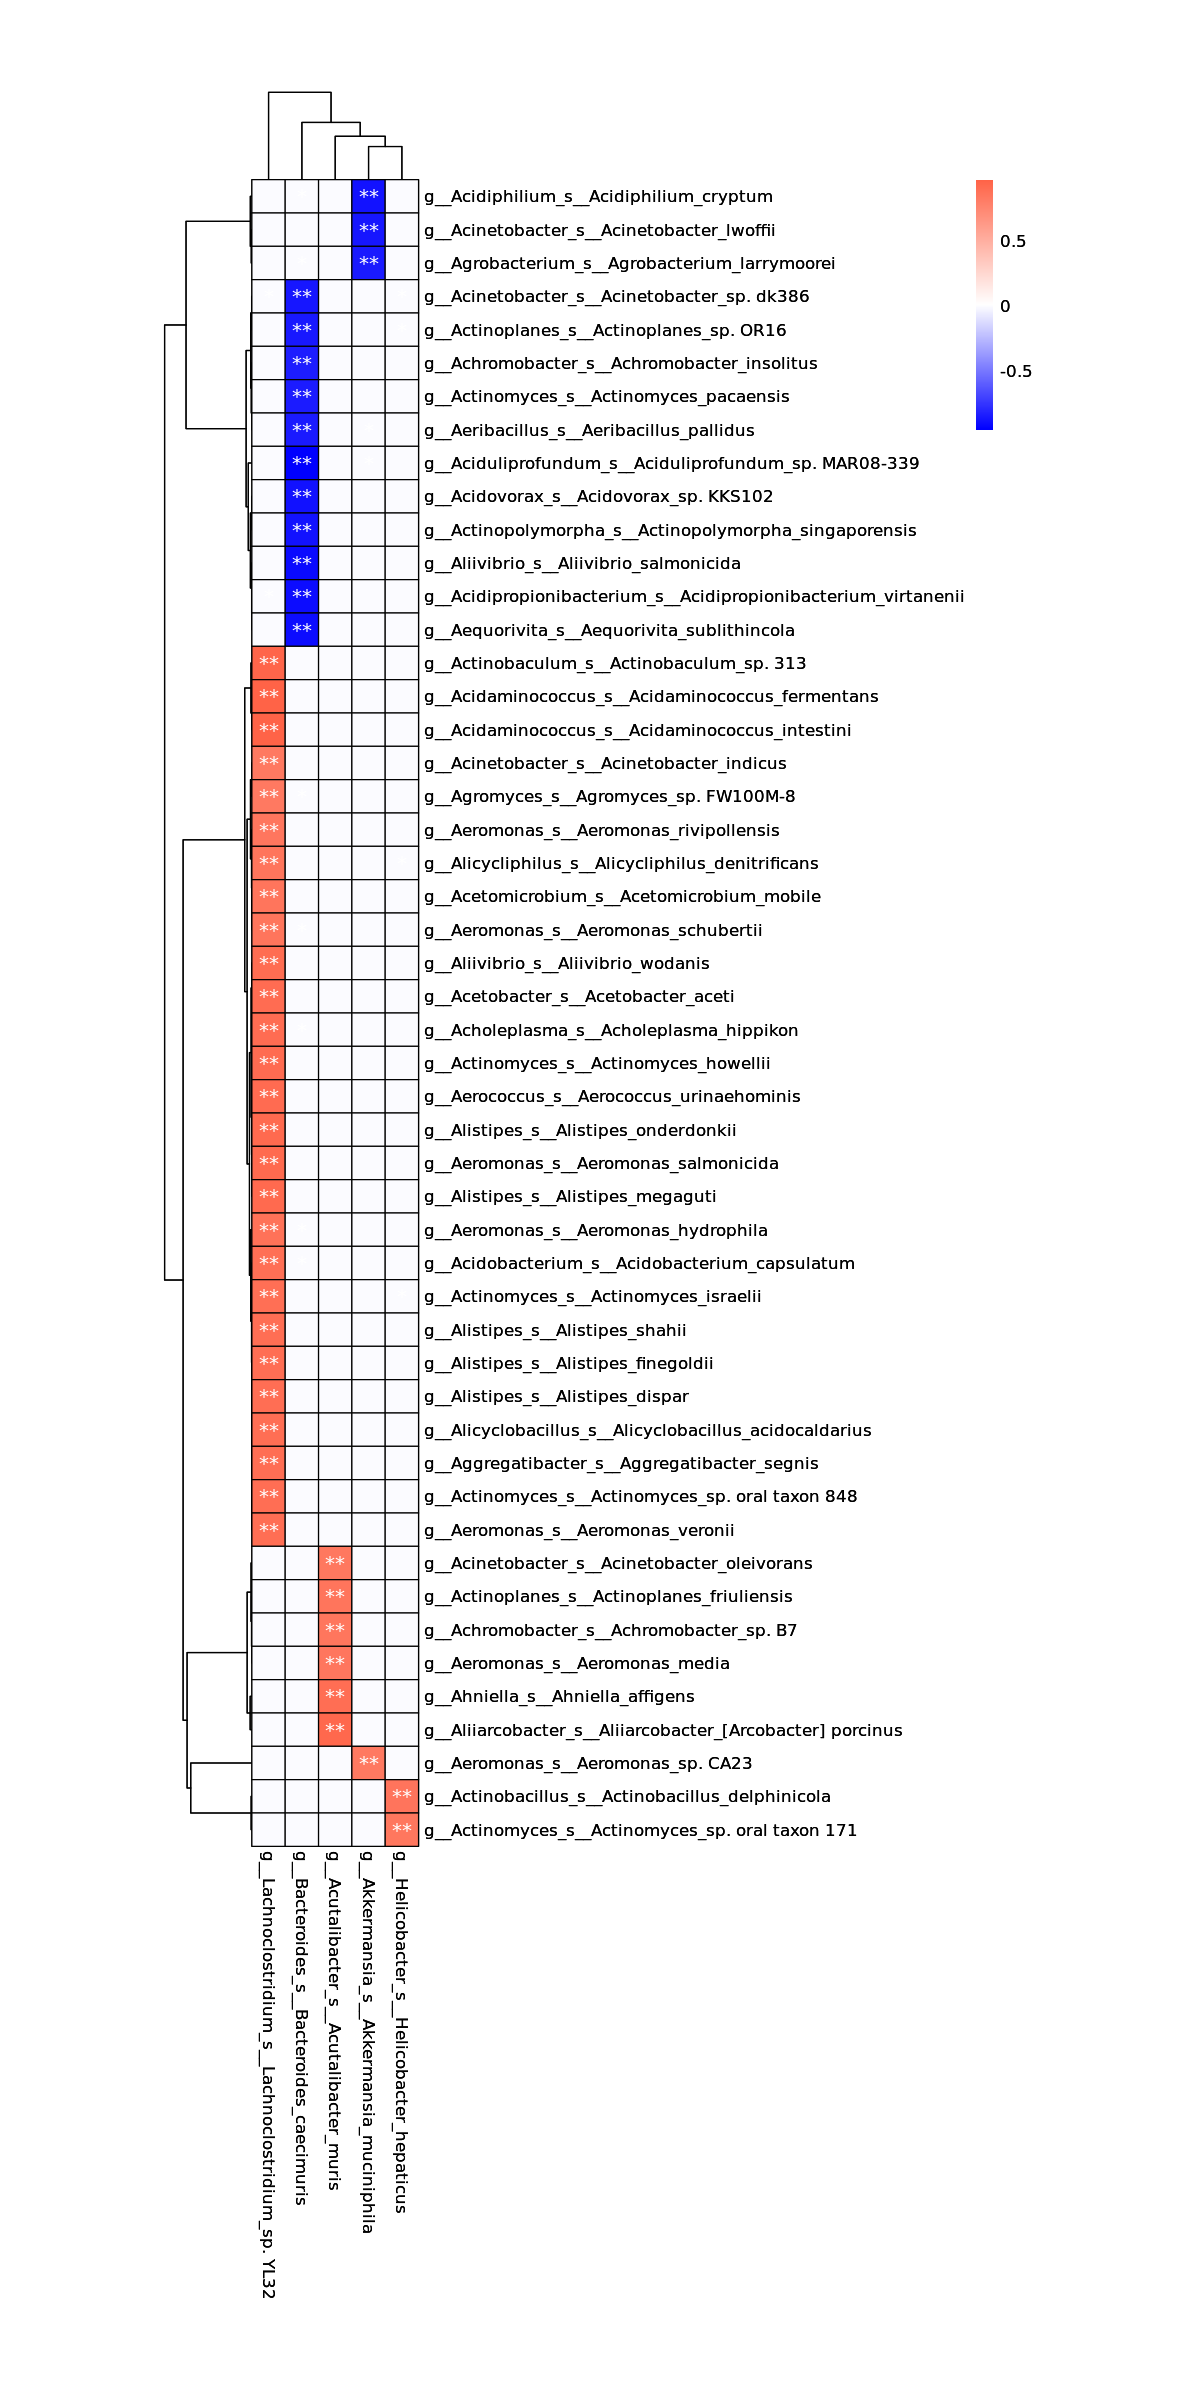

No id variables; using all as measure variables



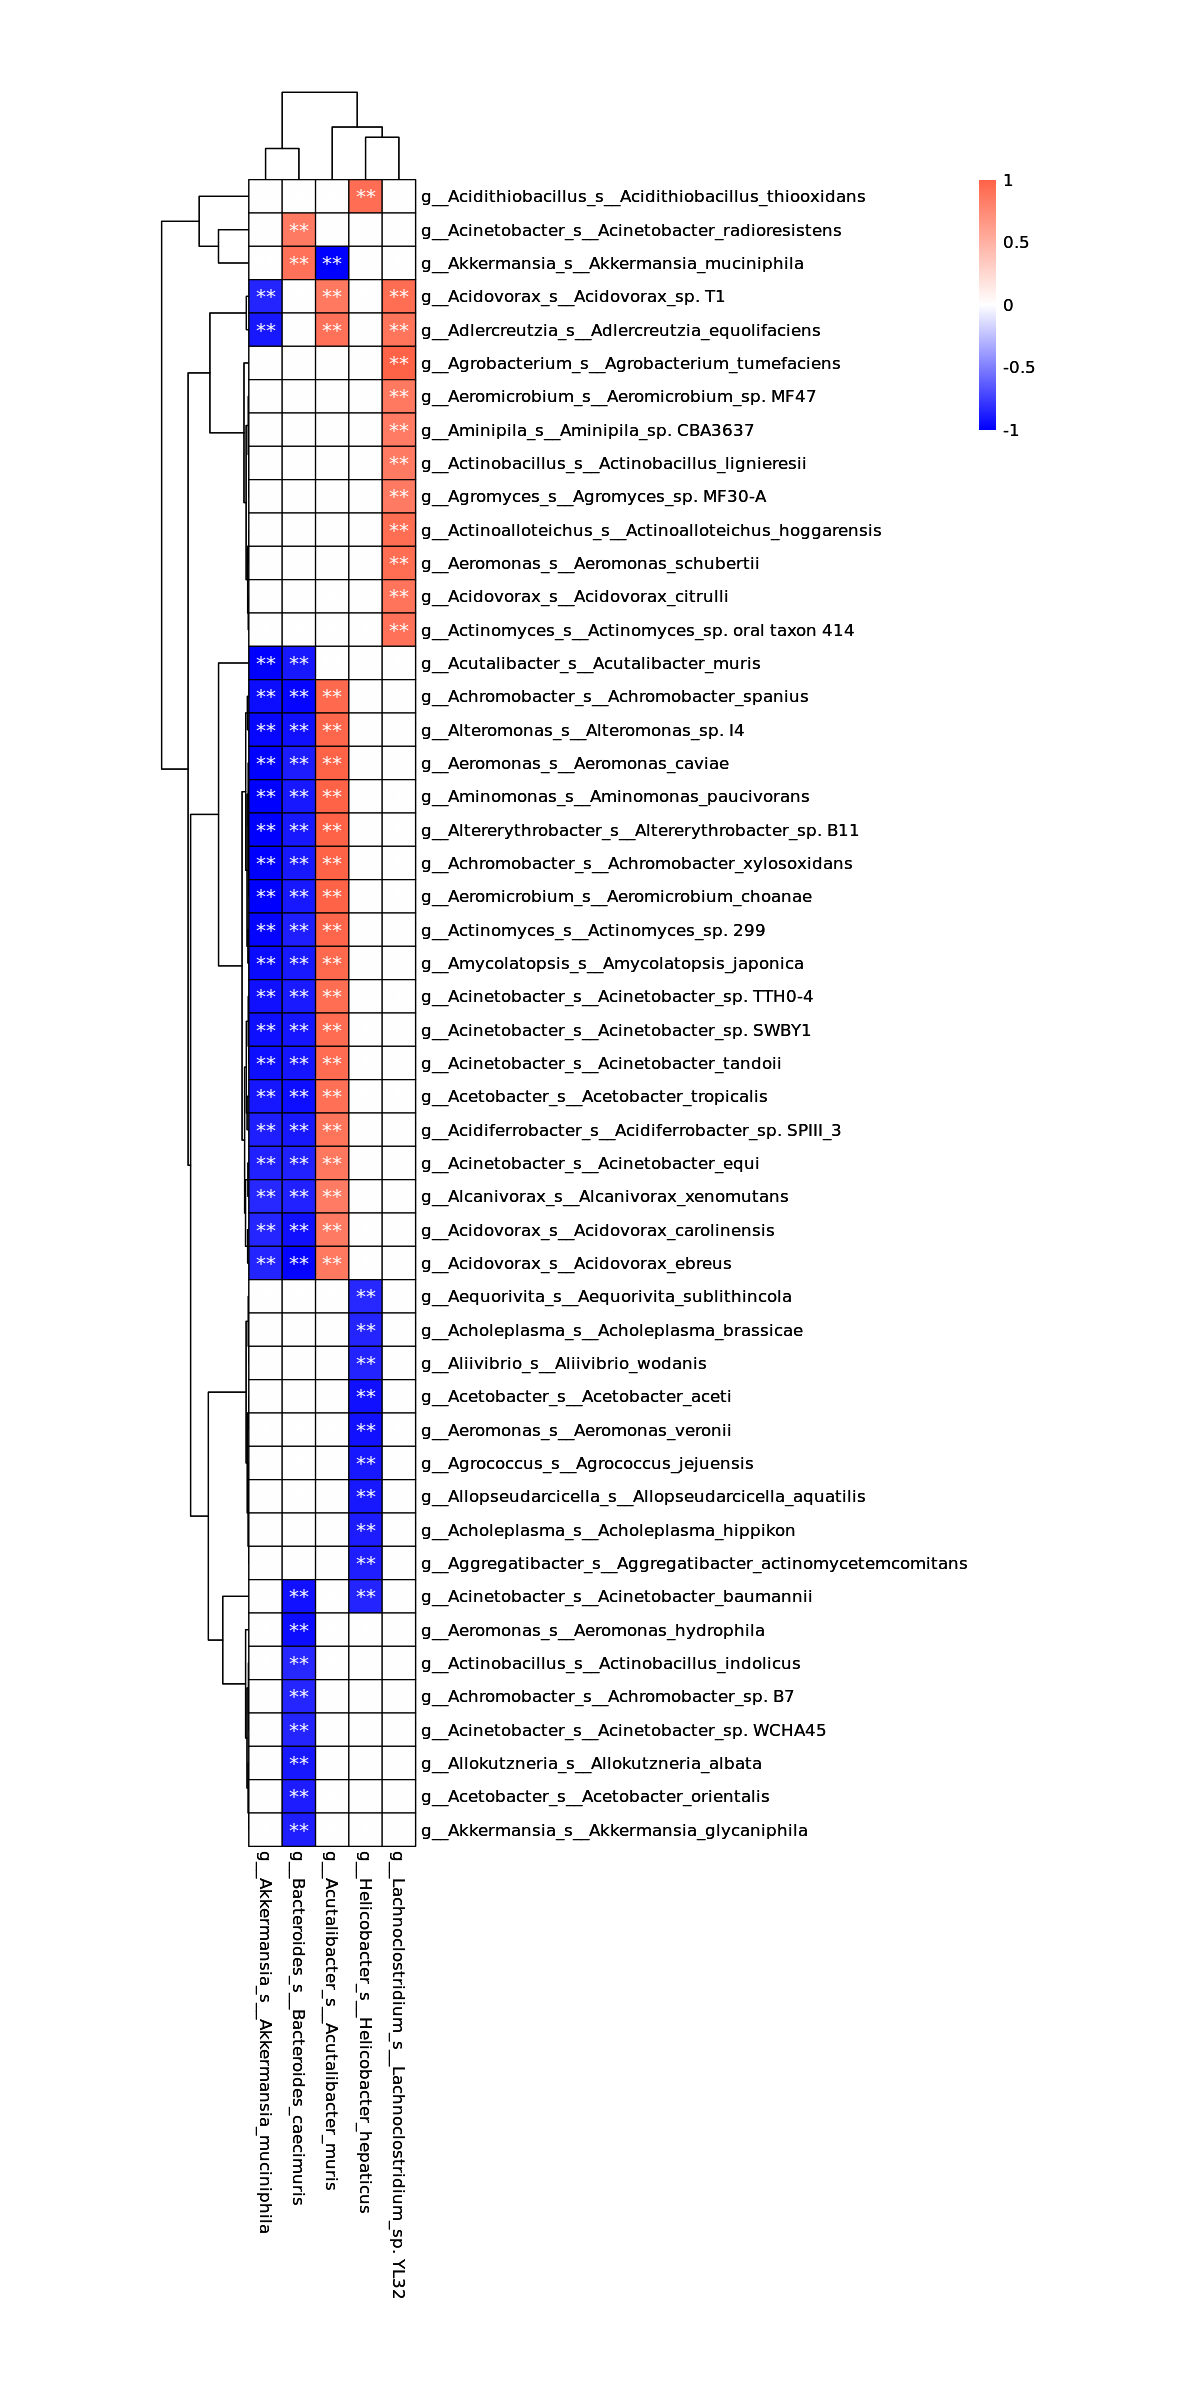

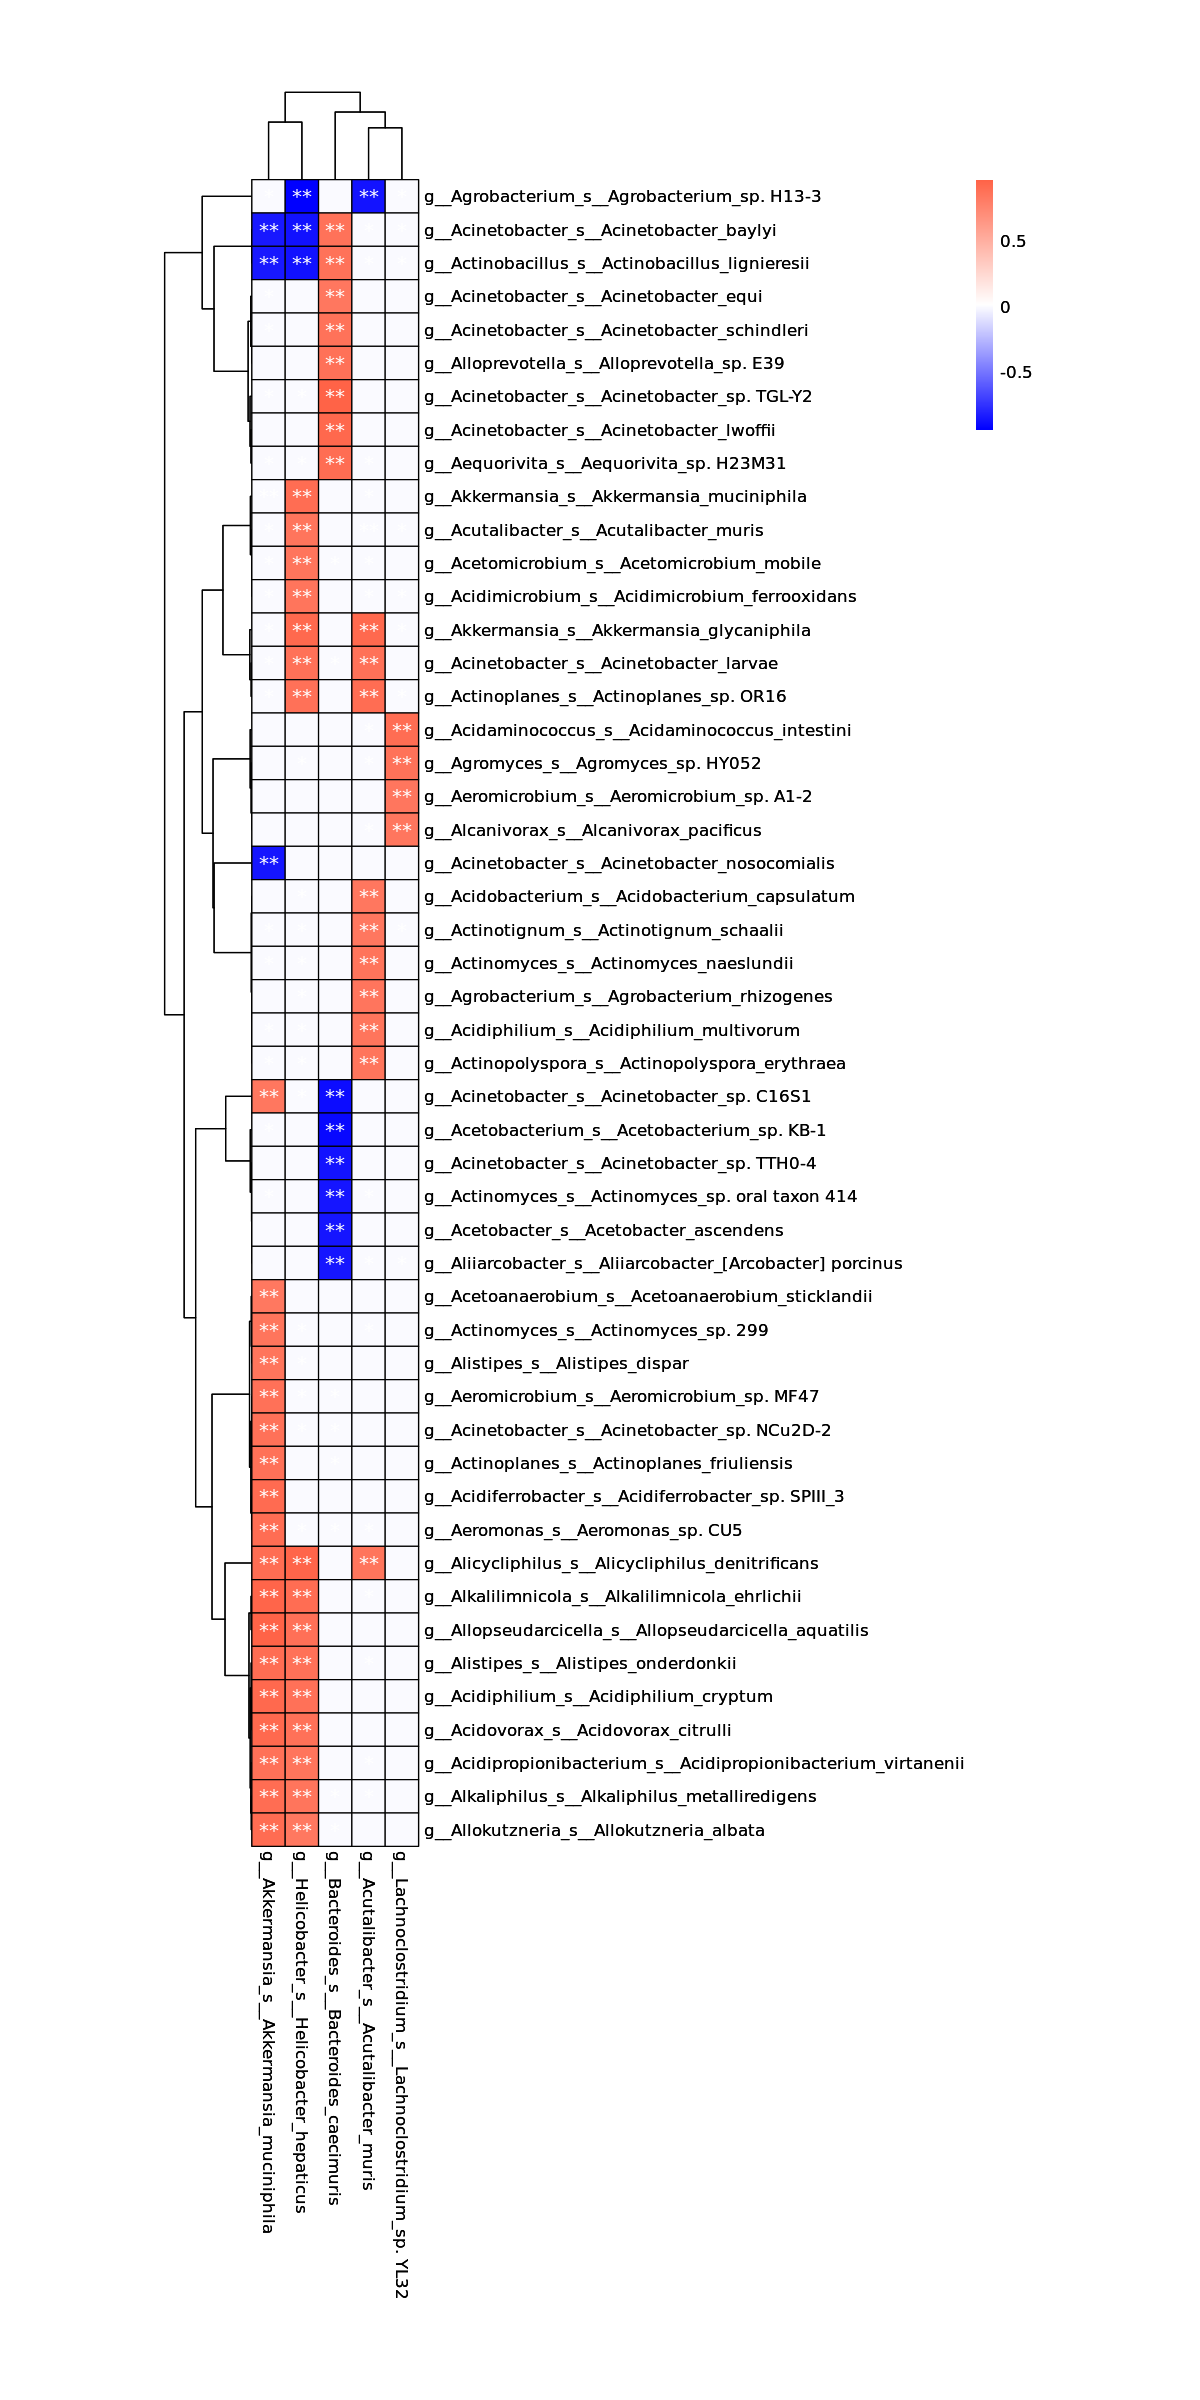

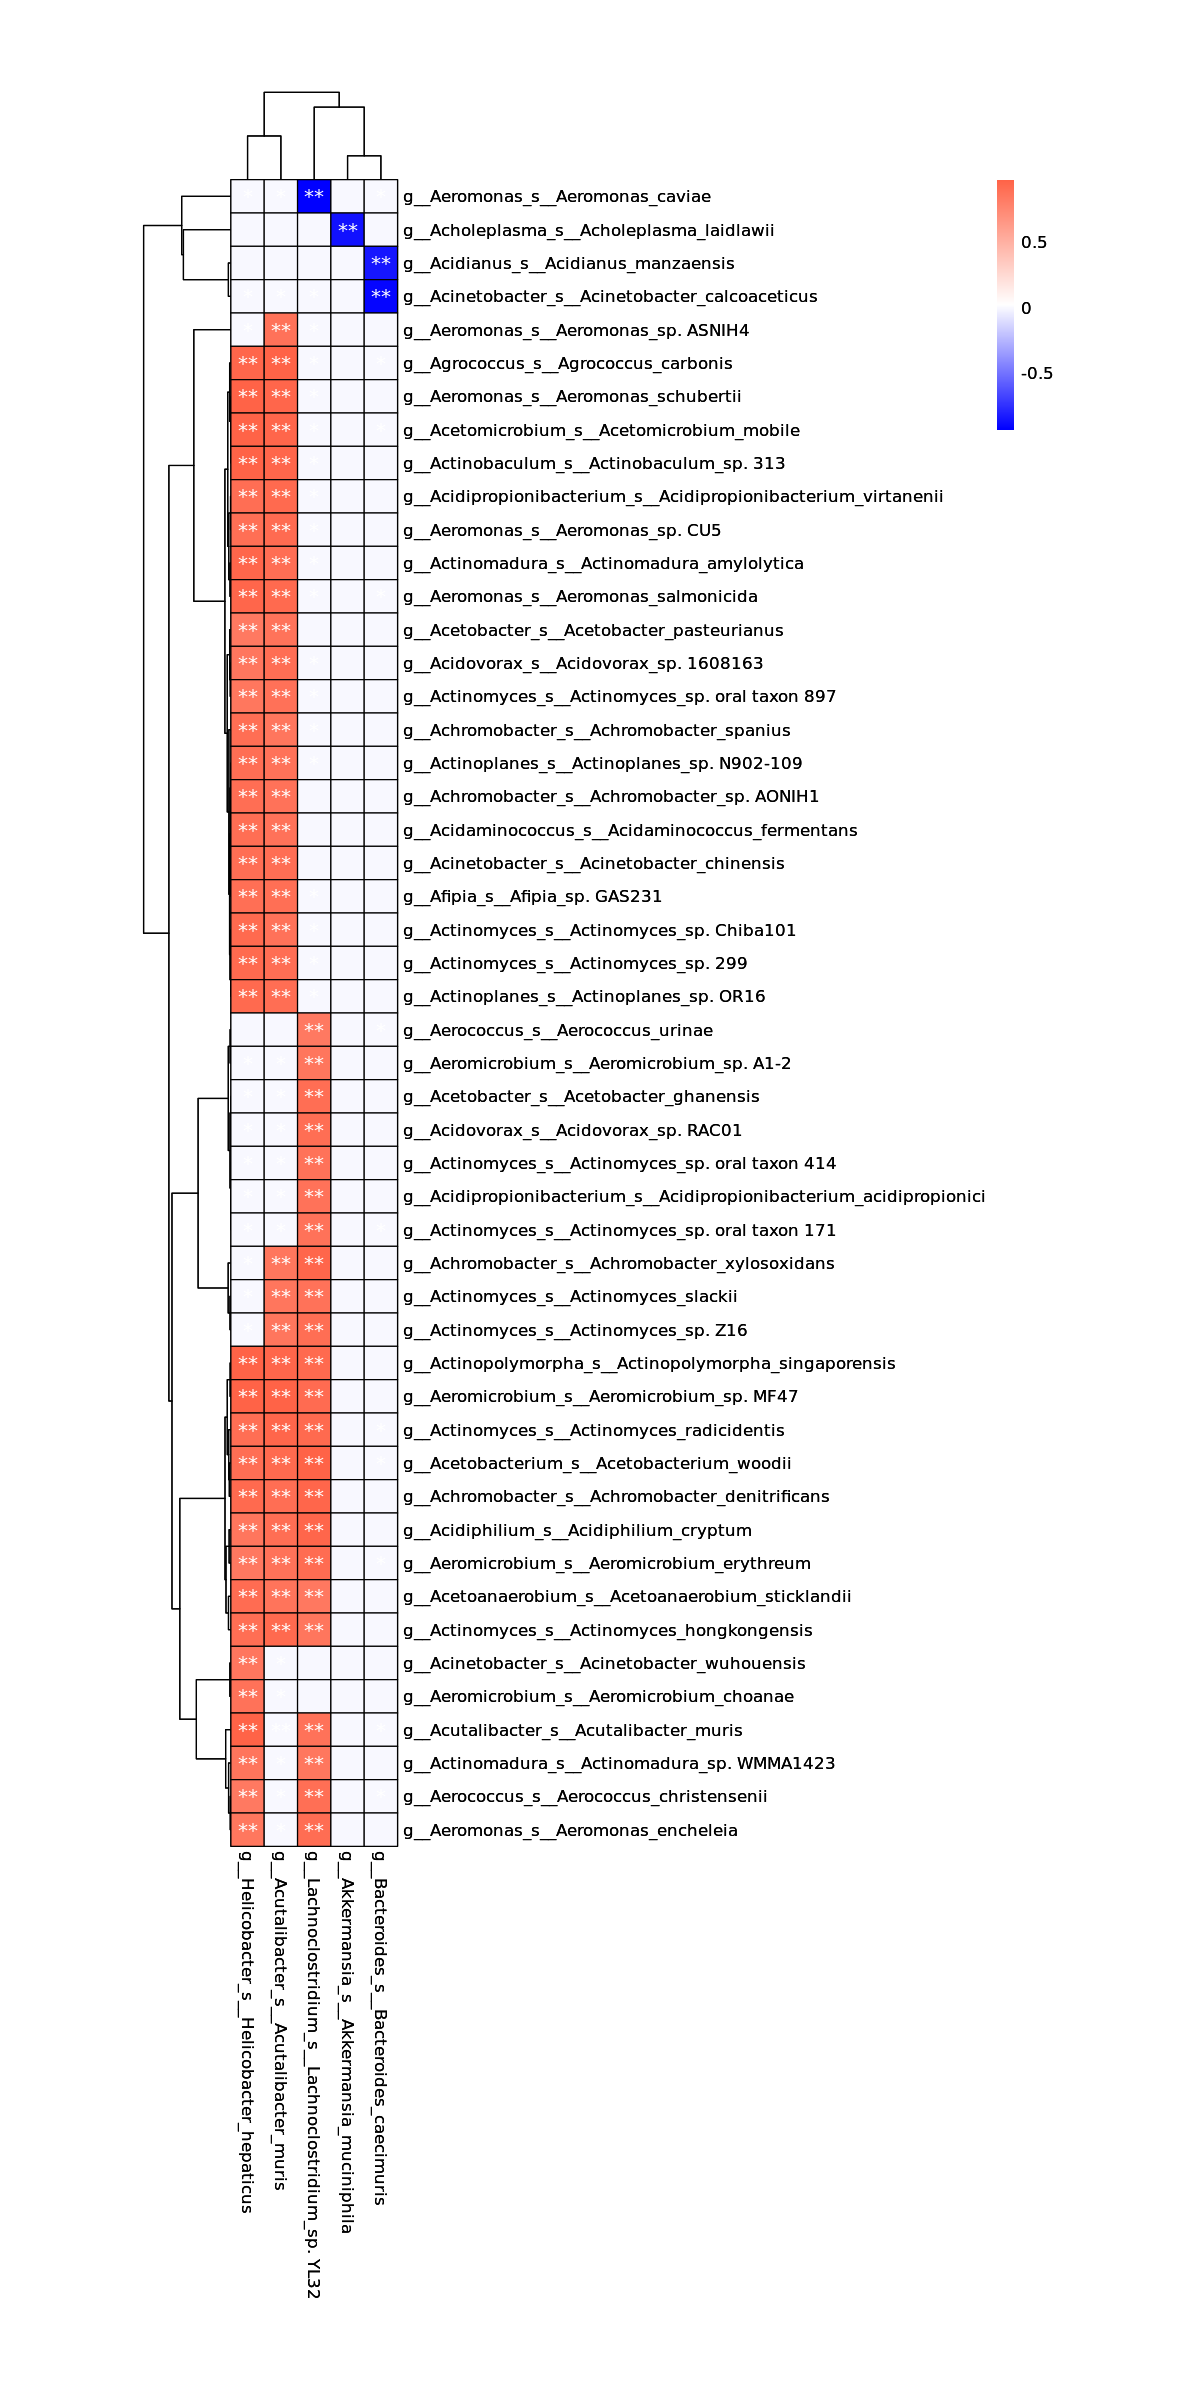

In [127]:
for (i in seq(1:4)){
cmt <-g[[i]]$r;pmt  = g[[i]]$p
    cmtout = cmt %>% as.data.frame() %>% select(kind) %>% filter(rowSums(.) != 0)

    pmtout = pmt[rownames(cmtout),colnames(cmtout)]
    
    cmt.out<- cmtout
    
    colnames(pmtout) = colnames(cmtout)
    rownames(pmtout) = rownames(cmtout)
    pmt.out = pmtout
    library(reshape2)
    library(pheatmap)
    df <-melt(cmtout,value.name= "cor")
    df$pvalue <- as.vector(pmtout)
    if(!is.null(pmtout)){
    ssmt <- pmtout< 0.01
    pmtout[ssmt] <- '**'
    smt <- pmtout > 0.01& pmtout < 0.05
    pmtout[smt] <- '*'
    pmtout[!ssmt&!smt]<- ''
    } else{
    pmtout <- F
    }

    mycol<-colorRampPalette(c("blue","white","tomato"))(800)
    options(repr.plot.height = 20,repr.plot.width = 10)
    p = pheatmap(cmtout[1:50,],scale = "none",cluster_row = T, cluster_col = T, border='black',
    display_numbers = pmtout[1:50,],fontsize_number = 12, number_color = "white",
    cellwidth = 20, cellheight =20,color=mycol)
    
    print(p)
    write.csv(cmtout,file = paste0(outdir,'/',names(g)[[i]],'.cor.r.csv'))
    write.csv(pmtout,file = paste0(outdir,'/',names(g)[[i]],'.cor.p.csv'))
    ggsave(p,file = paste0(outdir,'/',names(g)[[i]],'.heatmap.pdf'),height = 20,width = 10)
    

    
}

[1] "KO.CLP" "KO.NC"  "WT.CLP" "WT.NC"

In [129]:
outdir = './4-bad.cor'

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(bad)

  # Now:
  data %>% select(all_of(bad))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



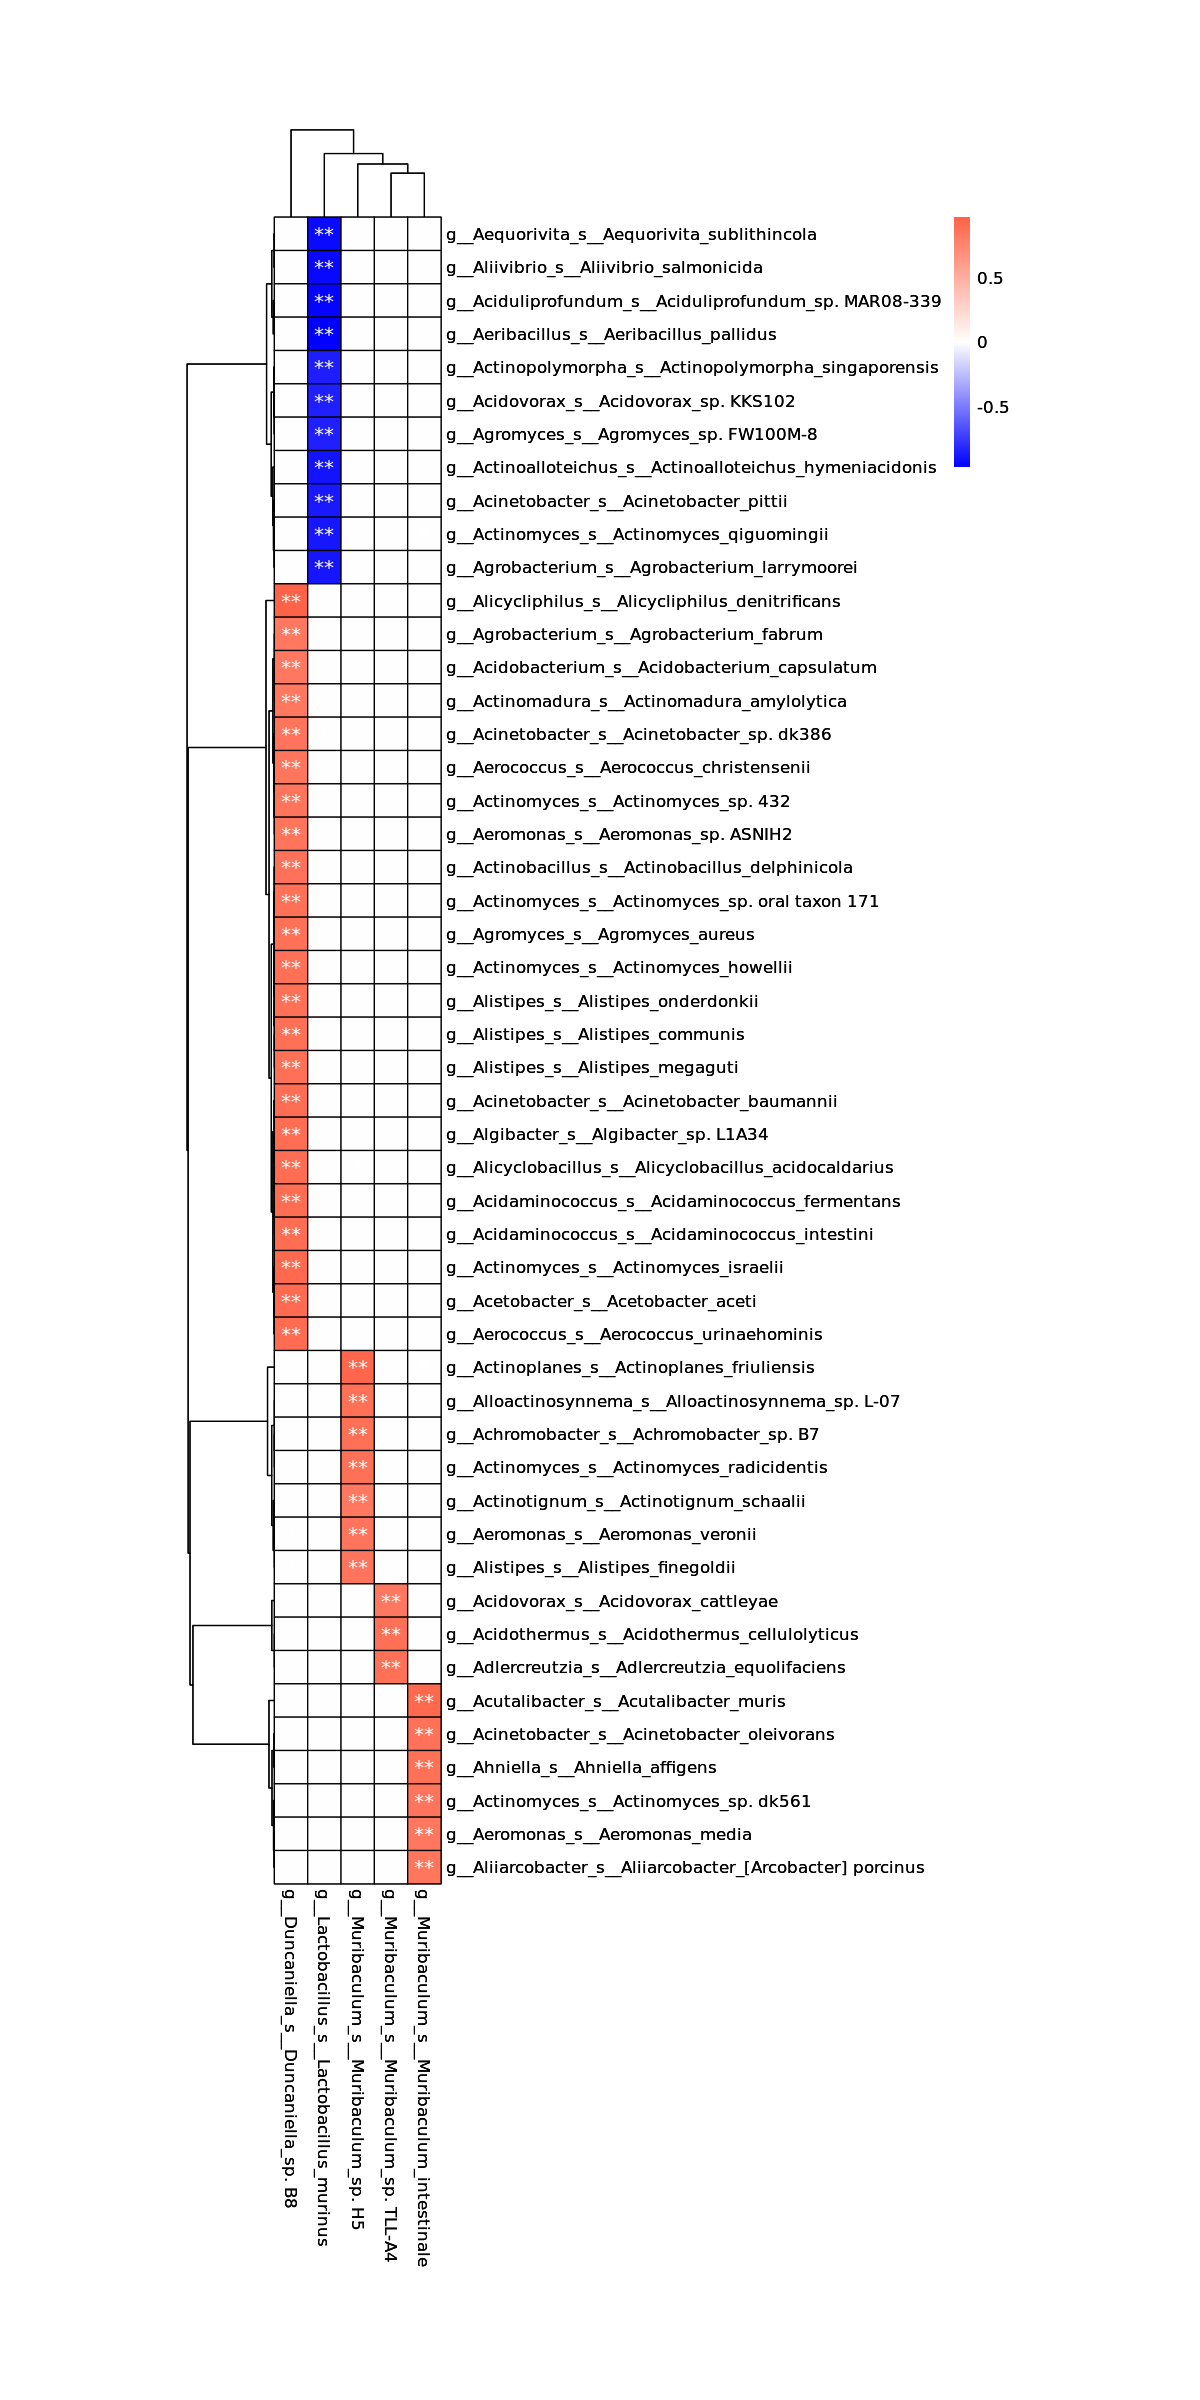

No id variables; using all as measure variables



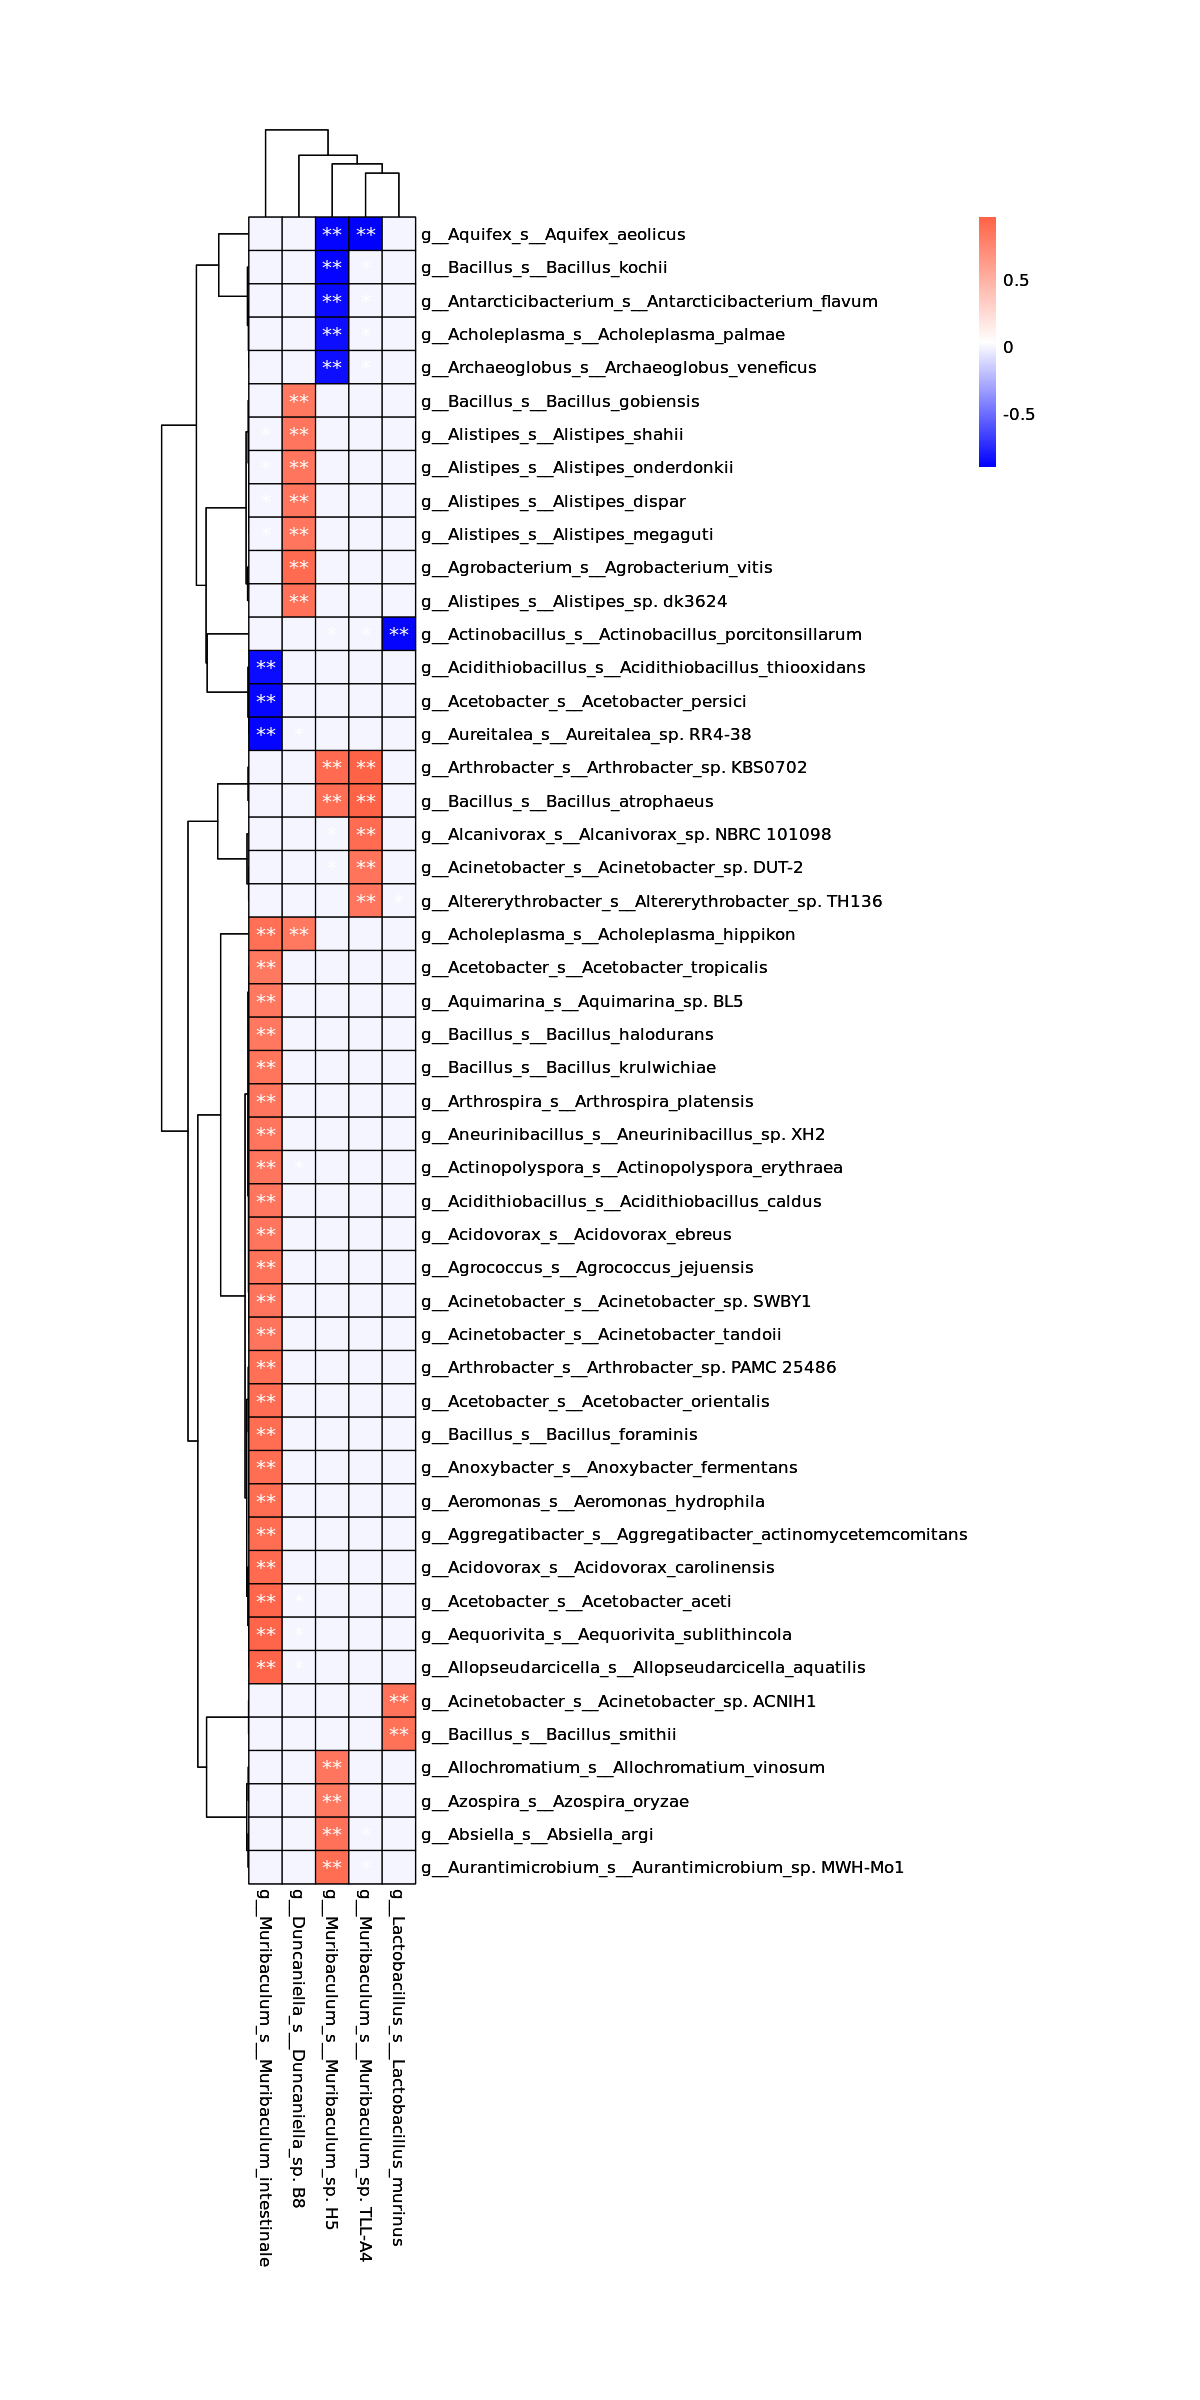

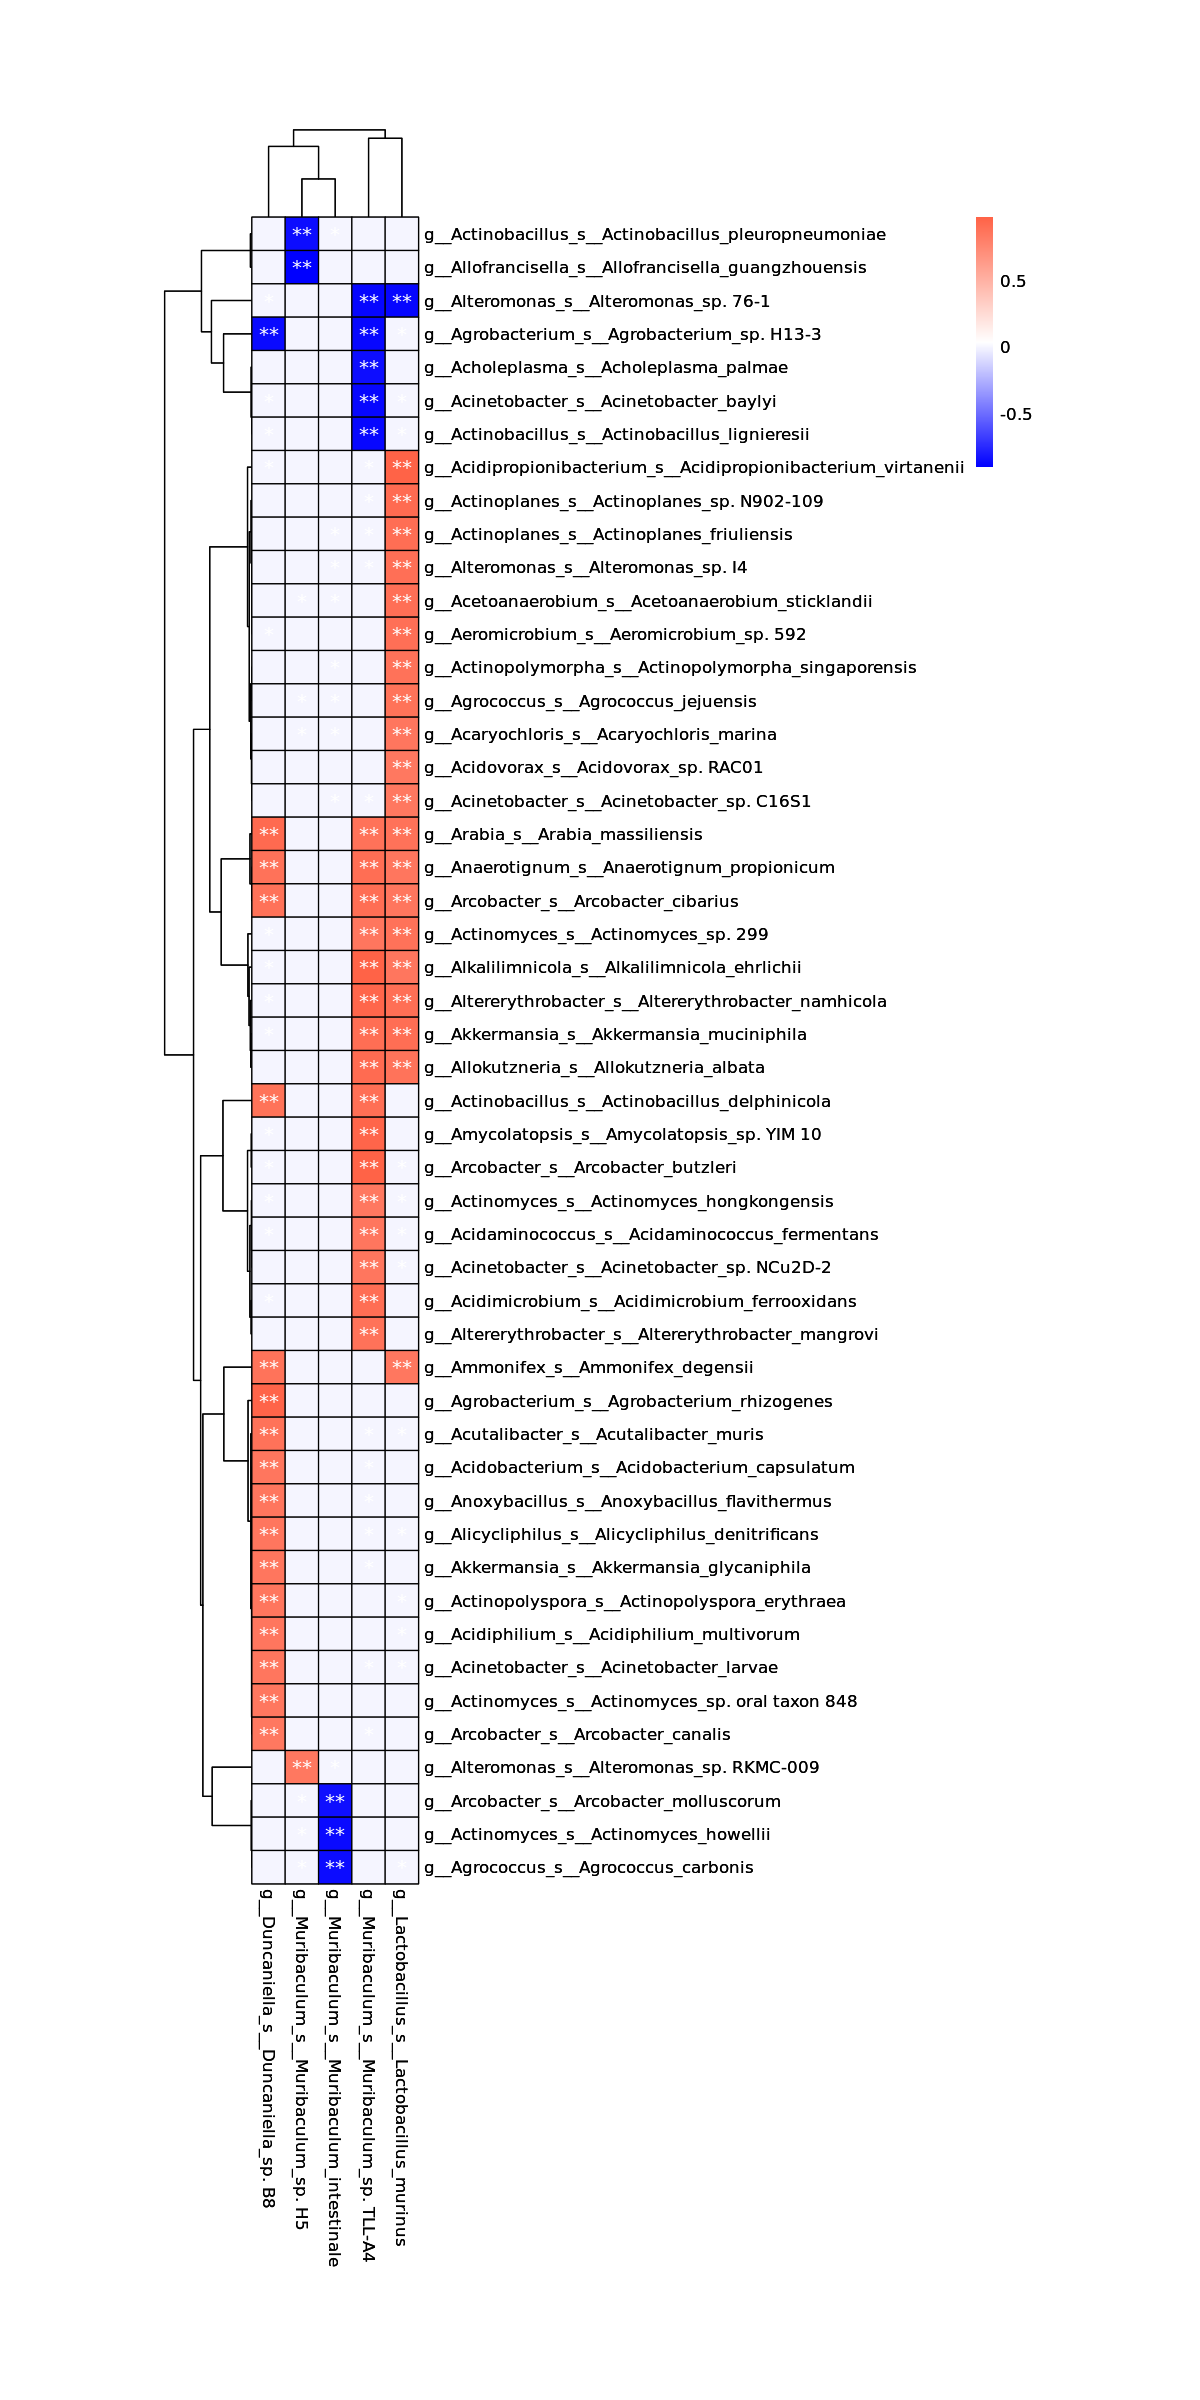

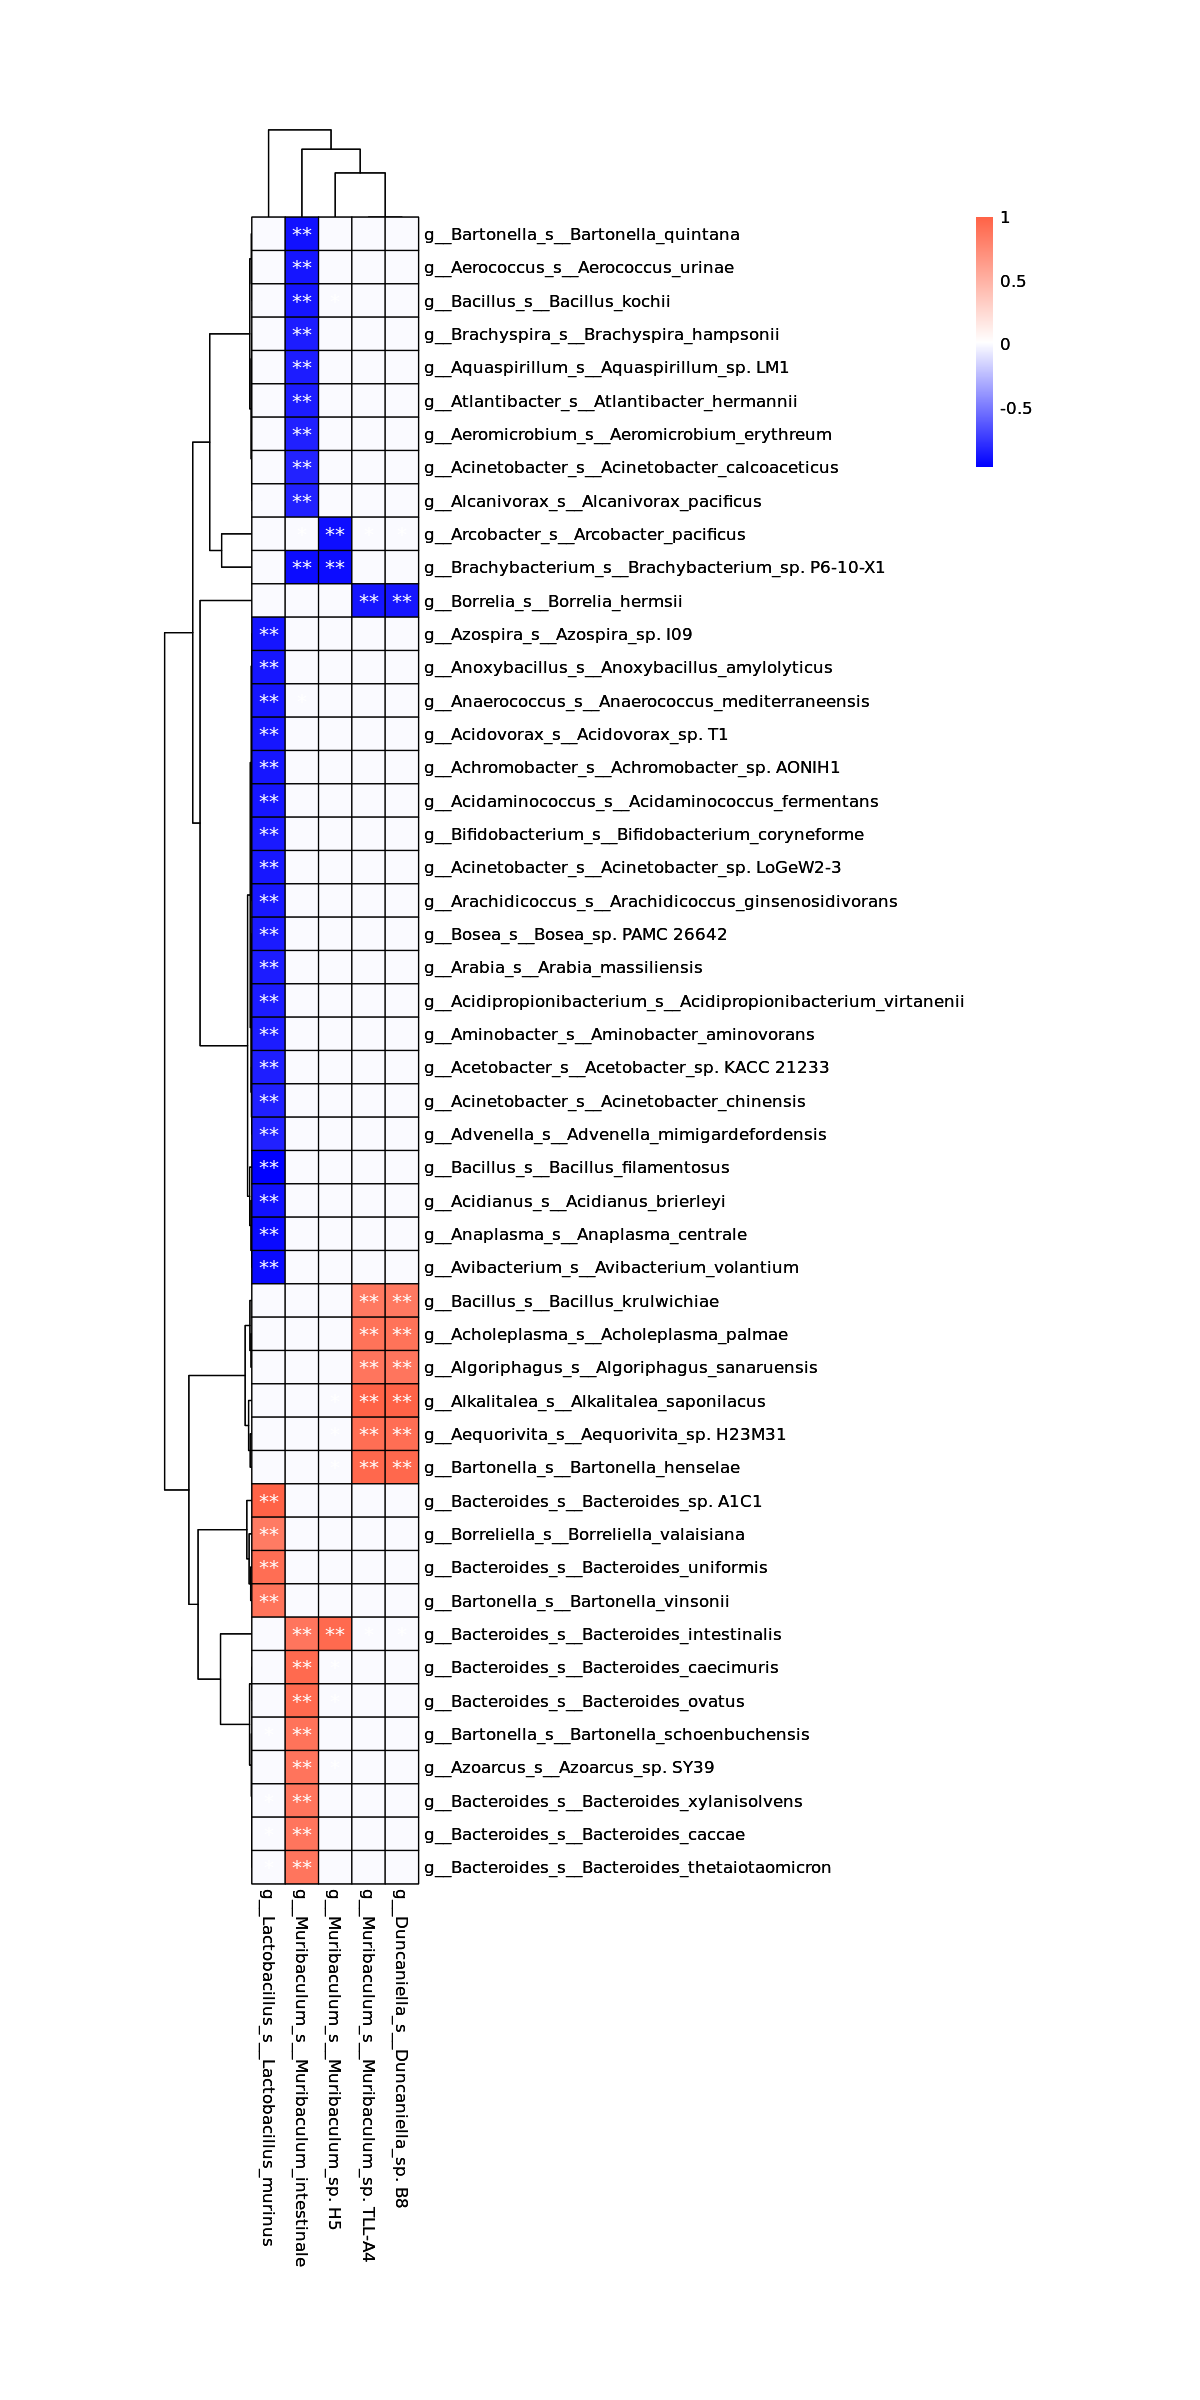

In [130]:
for (i in seq(1:4)){
cmt <-g[[i]]$r;pmt  = g[[i]]$p
    cmtout = cmt %>% as.data.frame() %>% select(bad) %>% filter(rowSums(.) != 0)

    pmtout = pmt[rownames(cmtout),colnames(cmtout)]
    
    cmt.out<- cmtout
    
    colnames(pmtout) = colnames(cmtout)
    rownames(pmtout) = rownames(cmtout)
    pmt.out = pmtout
    library(reshape2)
    library(pheatmap)
    df <-melt(cmtout,value.name= "cor")
    df$pvalue <- as.vector(pmtout)
    if(!is.null(pmtout)){
    ssmt <- pmtout< 0.01
    pmtout[ssmt] <- '**'
    smt <- pmtout > 0.01& pmtout < 0.05
    pmtout[smt] <- '*'
    pmtout[!ssmt&!smt]<- ''
    } else{
    pmtout <- F
    }

    mycol<-colorRampPalette(c("blue","white","tomato"))(800)
    options(repr.plot.height = 20,repr.plot.width = 10)
    p = pheatmap(cmtout[1:50,],scale = "none",cluster_row = T, cluster_col = T, border='black',
    display_numbers = pmtout[1:50,],fontsize_number = 12, number_color = "white",
    cellwidth = 20, cellheight =20,color=mycol)
    
    print(p)
    write.csv(cmtout,file = paste0(outdir,'/',names(g)[[i]],'.cor.r.csv'))
    write.csv(pmtout,file = paste0(outdir,'/',names(g)[[i]],'.cor.p.csv'))
    ggsave(p,file = paste0(outdir,'/',names(g)[[i]],'.heatmap.pdf'),height = 20,width = 10)
    

    
}

In [ ]:
pdf("4.cor/network3.pdf", encoding="MacRoman", width=18, height=9)
par(mfrow=c(1,4),mar=c(0,0,1,0),font.main=4)
for(j in 1:4){
  g1 <- g[[j]]$g
    outdir = paste('4.cor',names(g)[j],sep = "/")
    if(dir.exists(outdir)){
      print("dir exists")
    }else{
      dir.create(outdir)
    }
#write.csv(igraph::as_data_frame(g1, what = "both")$edges,file =paste0(outdir,'/','network.df.csv'),quote =F,row.names =F)
    
  E(g1)$correlation <- E(g1)$weight
  E(g1)$weight <- abs(E(g1)$weight)
  set.seed(007)
  V(g1)$modularity <- membership(cluster_fast_greedy(g1))
 
  V(g1)$label <- V(g1)$name
  V(g1)$label <- NA
  modu_sort <- V(g1)$modularity %>% table() %>% sort(decreasing = T)
 
  top_num <- 8
  modu_name <- names(modu_sort[1:8])
  modu_cols <- cols[1:length(modu_name)]
  names(modu_cols) <- modu_name
  V(g1)$color <- V(g1)$modularity
  V(g1)$color[!(V(g1)$color %in% modu_name)] <- col_g
  V(g1)$color[(V(g1)$color %in% modu_name)] <- modu_cols[match(V(g1)$color[(V(g1)$color %in% modu_name)],modu_name)]
  V(g1)$frame.color <- V(g1)$color
 
  E(g1)$color <- col_g
  for ( i in modu_name){
    col_edge <- cols[which(modu_name==i)]
    otu_same_modu <-V(g1)$name[which(V(g1)$modularity==i)]
    E(g1)$color[(data.frame(as_edgelist(g1))$X1 %in% otu_same_modu)&(data.frame(as_edgelist(g1))$X2 %in% otu_same_modu)] <- col_edge
  }
  sub_net_layout <- layout_with_fr(g1, niter=999,grid = 'nogrid')
  plot(g1,layout=sub_net_layout, edge.color = E(g1)$color,vertex.size=2)
  title(main = paste0('group=',names(g)[j],',' , 'Nodes=',length(V(g1)$name),', ','Edges=',nrow(data.frame(as_edgelist(g1)))))
}
dev.off()

Warning message in plot.new():
“Cannot open temporary file '/tmp/RtmpPw0Dr6/pdfee184d1b69d3' for compression (reason: No such file or directory); compression has been turned off for this device”


### 单个样本

In [299]:
library(dplyr)
library(reshape2)
library(tidyr)
OTU_connect_target = function(path,name,otuname){

    cor.r = read.csv(paste0(path,name,'.cor.r.csv'),row.names = 1)
    cor.p = read.csv(paste0(path,name,'.cor.p.csv'),row.names = 1)
    cor.r  = cor.r[!grepl(paste(otuname, collapse = "|"), rownames(cor.r)),]
    cor.p  = cor.p[!grepl(paste(otuname, collapse = "|"), rownames(cor.p)),]
cor.r$from = rownames(cor.r) 
cor.p$from = rownames(cor.p)
    p = cor.p %>% 
  gather(key = "to", value = "p", -from) %>%
  data.frame()
 
cor.data = cor.r %>% 
  gather(key = "to", value = "r", -from) %>%
  data.frame() %>%
  left_join(p, by=c("from","to")) %>%
  filter(p <= 0.01, from != to) %>%
  mutate(
    linecolor = ifelse(r > 0,"positive","negative"), # 设置链接线属性，可用于设置线型和颜色。
    linesize = abs(r) # 设置链接线宽度。
    ) # 此输出仍有重复链接，后面需进一步去除。
cor.data = filter(cor.data,r != 0)
type = as.data.frame(c(otuname,rownames(cor.r)))
    
type$group = c(rep('Inner',dim(cor.r)[2]-1),
              rep('Outer',dim(cor.r)[1]))

    
type$type = c(rep('Inner',dim(cor.r)[2]-1),
              rep('Outer',dim(cor.r)[1]))

colnames(type)[1] = 'name'
library(dplyr)

c(as.character(cor.data$from),as.character(cor.data$to)) %>%
  as_tibble() %>%
  group_by(value) %>%
  dplyr::summarize(n=n()) -> vertices
colnames(vertices) <- c("name", "n")
 
## 3.1.2 添加变量分类属性
vertices <- vertices %>%
  select(-n) %>% # 因为此处的n不准确，所以先删除。
  left_join(type,by="name")
 
## 3.1.3 对节点属性表进行排序
#网络图中节点会按照节点属性文件的顺序依次绘制，
##为了使同类型变量位置靠近，按照节点属性对节点进行排序。
##环境变量最好置于表格末尾，否则后续绘图可能会效果不好
##此处使用type进行排序，依次是细菌、真菌和环境因子,
##然后按照group排序，使同一属的物种彼此靠近。
vertices$type <- factor(vertices$type,
                        levels = c("Inner","Outer" ))
vertices <- vertices %>%
  arrange(type,group) 

cor.data = na.omit(cor.data)
 
## 3.2.1 构建graph数据结构
graph <- graph_from_data_frame(cor.data, vertices = vertices, directed = FALSE )
graph # 非简单图

## 3.2.2 转为简单图，去除cor.data数据表中的重复链接
is.simple(graph) # 非简单图，链接数会偏高，所以需要转换为简单图。
E(graph)$weight <- 1 # 将链接权重赋值为1
graph <- igraph::simplify(graph,edge.attr.comb = "first")# 转为简单图
is.simple(graph)
E(graph)$weight <- 1 # 将链接权重赋值为1
is.weighted(graph)
graph

 
# 3.3 重新计算每个节点具有的链接数(degree)
V(graph)$degree <- degree(graph)

 
# 3.4 保存绘图数据到本地
#write.graph(graph,file = "graph.gml",format="gml") # 直接保存graph结构，gml能保存的graph信息最多。
net.data  <- igraph::as_data_frame(graph, what = "both")$edges # 提取链接属性
#write.csv(net.data,"net.data.csv",quote = FALSE,col.names = NA,row.names = FALSE) # 保存结果到本地。
head(net.data)
 
vertices  <- igraph::as_data_frame(graph, what = "both")$vertices # 提取节点属性
#write.csv(vertices,"vertices.csv",quote = FALSE,col.names = NA,row.names = FALSE)
head(vertices) # 直接读入此步保存的链接和节点属性文件，之后可直接生成graph或用于其他绘图软件绘图。

 
# 4.1 设置颜色
## 4.1.1 节点分组颜色
unique(vertices$group) # 7个分组信息
#??ggsci # 查看ggsci包帮助文件，选择颜色。
library(ggsci)
library(scales)
mycolor = pal_d3("category20",alpha = 1)(20)
mycolor
cols = mycolor[c(1:7,9:13,14)]
show_col(cols) # 以图形形式展示颜色
 
## 4.1.2 链接线颜色
#linetypes = c("positive" ="solid","negative" ="dashed") # 设置线类型
color = c("positive" ="#D62728FF","negative" ="#2CA02CFF")

 
# 4.2 方法1: 手动计算节点坐标
##添加标签角度数据
## seq()生成一组1-数据表行数的数值。
#number_of_bar<-nrow(vertices)
#vertices$id = seq(1, nrow(vertices))
#angle= 360 * (vertices$id-0.5) /number_of_bar 
#vertices$hjust<-ifelse(angle>180, 1, 0)
#vertices$angle<-ifelse(angle>180, 90-angle+180, 90-angle)
##物种与环境因子位于一个环上，则运行上面的代码。
 
## 4.2.1 为物种和环境因子标签分别生成角度
### 计算各类型变量总数
bar1 = nrow(vertices[vertices$group == "Inner",])
bar1 # 9个环境因子
bar2 = nrow(vertices[vertices$group != "Inner",])
bar2 # 17个物种
 
### 为各变量添加序号
vertices$id =1
vertices$id[vertices$group == "Inner"] = seq(1, bar1)
vertices$id[vertices$group != "Inner"] = seq(1, bar2)
head(vertices)
 
### 计算变量与轴的角度
vertices$var_angel <- NA
vertices$var_angel[vertices$group == "Inner"] <- 360 * (vertices$id[vertices$group == "Inner"]-0.5)/bar1 
vertices$var_angel[vertices$group != "Inner"] <- 360 * (vertices$id[vertices$group != "Inner"]-0.5)/bar2
 
### 计算物种和环境因子坐标-物种环半径设为1，环境因子环半径为0.5。
vertices$x <- ifelse(vertices$group == "Inner",cos(vertices$var_angel)/2,cos(vertices$var_angel))
vertices$y <- ifelse(vertices$group == "Inner",sin(vertices$var_angel)/2,sin(vertices$var_angel))
head(vertices)
 
## 4.2.2 为物种和环境因子标签添加hjust和angle属性
vertices$hjust <- ifelse(vertices$var_angel > 180, 1, 0)
vertices$angle <- ifelse(vertices$var_angel > 180, 90-vertices$var_angel+180, 90-vertices$var_angel)
 
## 4.2.3 内环的环境因子标签，设置为在节点中心水平放置
vertices$hjust[vertices$group == "Inner"] = "center" # 或0.5
vertices$angle[vertices$group == "Inner"] = 0
#write.csv(vertices,"vertices.csv",quote = FALSE,row.names = FALSE) #保存结果到本地
head(vertices)
 

 
## 4.2.4 将group属性加入链接属性表
net.data <- net.data %>% 
    left_join(vertices,by=c('from'='name')) 
#write.csv(net.data,"net.data.csv",quote = FALSE,row.names = FALSE) # 保存结果到本地
head(net.data)
 
## 4.2.5 重新构建graph结构数据
graph <- graph_from_data_frame(net.data, vertices = vertices, directed = FALSE)
graph

 
## 4.2.6 create_layout()创建布局数据，并将其中的(x,y)替换为上面计算的坐标。
layout <- create_layout(graph,layout = 'linear', circular = TRUE)
head(layout)
layout$x <- vertices$x
layout$y <- vertices$y
head(layout)

dim(layout)



 
# 4.3.4  绘制径向布局网络图2
##根据物种属设置节点颜色；
##节点degree设置节点大小；
##相关性正负设置链接线颜色；
##使用r绝对值大小设置链接线粗细。
Correlation <- guide_legend(title="Correlation",
                            direction="vertical",
                            order=2,# 图例排列序号
                            ncol=1,
                            byrow=FALSE,
                            title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                            label.theme = element_text(
                                           size = 12,colour = "black")
                             )
 
width_legend <- guide_legend(title="|r|",
                             direction="vertical",
                             order=1,# 图例排列序号
                             ncol=1,
                             byrow=FALSE,
                             title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                             label.theme = element_text(
                                           size = 12,colour = "black")
                   )
 
size_legend <- guide_legend(title="Degree",
                            direction="vertical",
                            order=3,# 图例排列序号
                            ncol=2, # 图例排两列
                            byrow=FALSE,
                            title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                            label.theme = element_text(
                                           size = 12,colour = "black")
                                         )
 
fill_legend <- guide_legend(title="Species",
                            direction="vertical",
                            order=4,# 图例排列序号
                            ncol=2,
                            byrow=FALSE,
                            title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                            label.theme = element_text(
                                           size = 12,
                                           colour = "black",face = "italic")
                                         )
 
set_graph_style(plot_margin = margin(0,0,1,0))
net.cir2 <- ggraph(layout) +
  geom_edge_arc(aes(edge_colour = as.factor(linecolor),
                    edge_width = abs(r)*0.01
                    ),
                edge_alpha=0.9 ) + # 改用曲线链接。
    scale_edge_colour_manual(values=color,
                          breaks = c("positive","negative"),
                          guide = Correlation) +
  scale_edge_width(
                   breaks = seq(0.2,1,0.2),
                   label = seq(0.2,1,0.2),
                   range = c(0.2,1),
                   guide = width_legend )+
  geom_node_point(aes(size=degree, fill=as.factor(group)),
                  shape=21,alpha=1) +
  scale_fill_manual(values=cols,
                    guide = fill_legend) +
  scale_size(
             breaks = seq(3,max(vertices$degree),3),
             label = seq(3,max(vertices$degree),3),
             range = c(5, 15),
             guide = size_legend)+
  geom_node_text(aes(x = x, y=y,
                     label= ifelse(V(graph)$group == "Inner",as.character(name),""),
                 angle=angle,hjust=hjust,
                 #color = as.factor(group)
                     ),
                 color = "black",# 所有节点标签设置为黑色。
                 size=4.75,# 14pt
                 show.legend = FALSE) +
  ##添加物种标签，取消下面代码的注释即可##
    #geom_node_text(aes(x = x*1.4, y=y*1.4, # 物种与环境因子标签的放置方式不同，最好分别设置，
                     #label= ifelse(V(graph)$group != "env",as.character(name),""),
                 #angle=angle,hjust=hjust,
                 #    ),
                 #color = "black",# 所有节点标签设置为黑色。
                 #size=4.75,# 14pt
                 #show.legend = FALSE) +
  coord_fixed()+
  theme_graph()
 
### 输出pdf格式图片到本地-输出到本地之后，可用AI或pdf编辑器删除物种标签，初期探索数据的时候，把标签加上比较好。
cairo_pdf(paste0(path,i,".pdf"),height=8,width=10,family="Times")
print(net.cir2) # 节点标签过长，可只展示种名。
dev.off()

}

In [300]:
path = './4-bad.cor/'

In [301]:
r = list.files(path = path,pattern = '*.cor.r.csv')
p  = list.files(path = path,pattern = '*.cor.p.csv')

In [302]:
bad = c('g__Muribaculum_s__Muribaculum_sp..TLL.A4',
'g__Muribaculum_s__Muribaculum_sp..H5',
'g__Muribaculum_s__Muribaculum_intestinale',
'g__Duncaniella_s__Duncaniella_sp..B8',
'g__Lactobacillus_s__Lactobacillus_murinus'
)

In [303]:
otuname = bad

In [304]:
name = gsub('.cor.r.csv','',r)

Warning message:
“Existing variables `x` and `y` overwritten by layout variables”
Warning message:
“Existing variables `x` and `y` overwritten by layout variables”
Warning message:
“Existing variables `x` and `y` overwritten by layout variables”
Warning message:
“Existing variables `x` and `y` overwritten by layout variables”


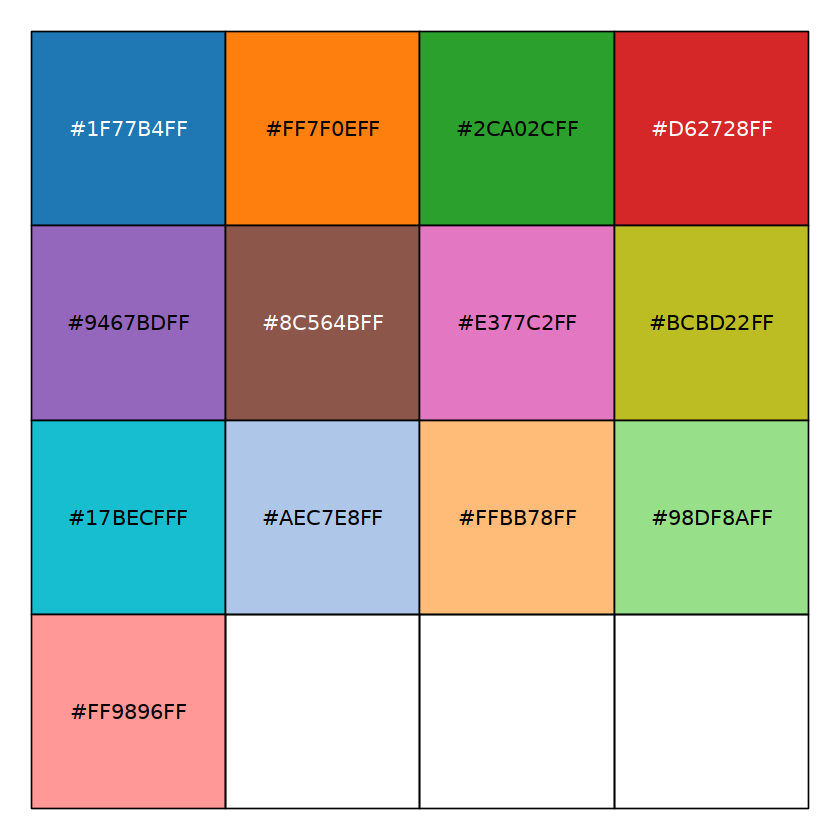

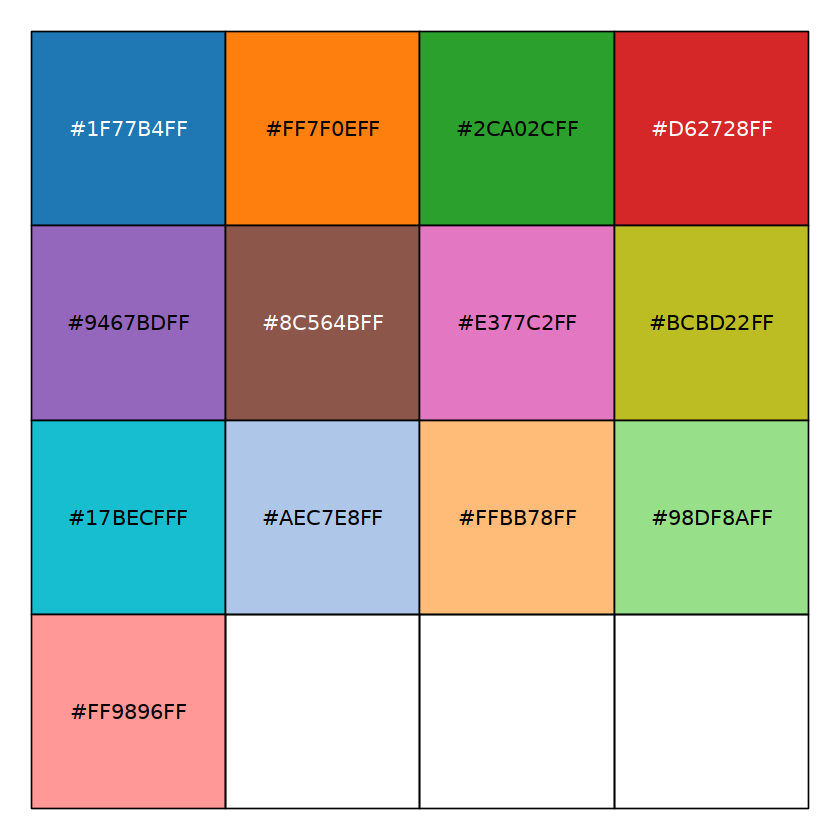

In [305]:
for (i in name){
OTU_connect_target(path,i,otuname)    
}

In [281]:
cor.r = read.csv('./4-bad.cor/WT.CLP.cor.r.csv',row.names = 1)

In [282]:
cor.p =  read.csv('./4-bad.cor/WT.CLP.cor.p.csv',row.names = 1)

In [283]:
cor.r  = cor.r[!grepl(paste(bad, collapse = "|"), rownames(cor.r)),]
cor.p  = cor.p[!grepl(paste(bad, collapse = "|"), rownames(cor.p)),]

### https://blog.csdn.net/qq_39859424/article/details/124462727

In [284]:
library(dplyr)
library(reshape2)
library(tidyr)

In [285]:
# 2.2 确定阈值：保留p<0.05的物种间相关关系
## 2.2.1 将数据转换为long format进行合并，过滤，并添加链接属性
cor.r$from = rownames(cor.r) 
cor.p$from = rownames(cor.p)

In [286]:

 
p = cor.p %>% 
  gather(key = "to", value = "p", -from) %>%
  data.frame()
 
cor.data = cor.r %>% 
  gather(key = "to", value = "r", -from) %>%
  data.frame() %>%
  left_join(p, by=c("from","to")) %>%
  filter(p <= 0.01, from != to) %>%
  mutate(
    linecolor = ifelse(r > 0,"positive","negative"), # 设置链接线属性，可用于设置线型和颜色。
    linesize = abs(r) # 设置链接线宽度。
    ) # 此输出仍有重复链接，后面需进一步去除。


In [287]:
cor.data = filter(cor.data,r != 0)

In [288]:
type = as.data.frame(c(bad,rownames(cor.r)))

In [289]:
type$group = c(rep('Inner',dim(cor.r)[2]-1),
              rep('Outer',dim(cor.r)[1]))

    
type$type = c(rep('Inner',dim(cor.r)[2]-1),
              rep('Outer',dim(cor.r)[1]))

In [290]:
bad = c('g__Muribaculum_s__Muribaculum_sp..TLL.A4',
'g__Muribaculum_s__Muribaculum_sp..H5',
'g__Muribaculum_s__Muribaculum_intestinale',
'g__Duncaniella_s__Duncaniella_sp..B8',
'g__Lactobacillus_s__Lactobacillus_murinus'
)

In [291]:
colnames(type)[1] = 'name'

In [292]:
library(dplyr)

In [293]:
length(unique(type$name))

[1] 756

In [294]:
c(as.character(cor.data$from),as.character(cor.data$to)) %>%
  as_tibble() %>%
  group_by(value) %>%
  dplyr::summarize(n=n()) -> vertices
colnames(vertices) <- c("name", "n")
 
## 3.1.2 添加变量分类属性
vertices <- vertices %>%
  select(-n) %>% # 因为此处的n不准确，所以先删除。
  left_join(type,by="name")
 
## 3.1.3 对节点属性表进行排序
#网络图中节点会按照节点属性文件的顺序依次绘制，
##为了使同类型变量位置靠近，按照节点属性对节点进行排序。
##环境变量最好置于表格末尾，否则后续绘图可能会效果不好
##此处使用type进行排序，依次是细菌、真菌和环境因子,
##然后按照group排序，使同一属的物种彼此靠近。
vertices$type <- factor(vertices$type,
                        levels = c("Inner","Outer" ))
vertices <- vertices %>%
  arrange(type,group) 
 
dim(vertices)
tail(vertices)


[1] 756   3

name,group,type
<chr>,<chr>,<fct>
g__un_p__Planctomycetes_s__NA_Planctomycetes bacterium Mal33,Outer,Outer
g__un_p__Planctomycetes_s__NA_Planctomycetes bacterium Pan153,Outer,Outer
g__un_p__Planctomycetes_s__NA_Planctomycetes bacterium Pan161,Outer,Outer
g__un_p__Planctomycetes_s__NA_Planctomycetes bacterium Pan258,Outer,Outer
g__un_p__Planctomycetes_s__NA_Planctomycetes bacterium Poly30,Outer,Outer
g__un_p__Planctomycetes_s__NA_Planctomycetes bacterium V6,Outer,Outer


In [295]:
# 3.1 准备节点属性文件
## 3.1.1 计算每个节点具有的链接数(degree)

 
## 3.2.1 构建graph数据结构
graph <- graph_from_data_frame(cor.data, vertices = vertices, directed = FALSE )
graph # 非简单图

IGRAPH b9e7a6a UN-B 756 1012 -- 
+ attr: name (v/c), group (v/c), type (v/c), r (e/n), p (e/c),
| linecolor (e/c), linesize (e/n)
+ edges from b9e7a6a (vertex names):
[1] g__Muribaculum_s__Muribaculum_sp..TLL.A4--g__Acholeplasma_s__Acholeplasma_palmae          
[2] g__Muribaculum_s__Muribaculum_sp..TLL.A4--g__Acidaminococcus_s__Acidaminococcus_fermentans
[3] g__Muribaculum_s__Muribaculum_sp..TLL.A4--g__Acidimicrobium_s__Acidimicrobium_ferrooxidans
[4] g__Muribaculum_s__Muribaculum_sp..TLL.A4--g__Acinetobacter_s__Acinetobacter_baylyi        
[5] g__Muribaculum_s__Muribaculum_sp..TLL.A4--g__Acinetobacter_s__Acinetobacter_sp. NCu2D-2   
+ ... omitted several edges

In [296]:
## 3.2.2 转为简单图，去除cor.data数据表中的重复链接
is.simple(graph) # 非简单图，链接数会偏高，所以需要转换为简单图。
E(graph)$weight <- 1 # 将链接权重赋值为1
graph <- igraph::simplify(graph,edge.attr.comb = "first")# 转为简单图
is.simple(graph)
E(graph)$weight <- 1 # 将链接权重赋值为1
is.weighted(graph)
graph

 
# 3.3 重新计算每个节点具有的链接数(degree)
V(graph)$degree <- degree(graph)


[1] TRUE

[1] TRUE

[1] TRUE

IGRAPH 5cdedf5 UNWB 756 1012 -- 
+ attr: name (v/c), group (v/c), type (v/c), r (e/n), p (e/c),
| linecolor (e/c), linesize (e/n), weight (e/n)
+ edges from 5cdedf5 (vertex names):
[1] g__Duncaniella_s__Duncaniella_sp..B8--g__Acidiphilium_s__Acidiphilium_multivorum      
[2] g__Duncaniella_s__Duncaniella_sp..B8--g__Acidobacterium_s__Acidobacterium_capsulatum  
[3] g__Duncaniella_s__Duncaniella_sp..B8--g__Acinetobacter_s__Acinetobacter_larvae        
[4] g__Duncaniella_s__Duncaniella_sp..B8--g__Actinobacillus_s__Actinobacillus_delphinicola
[5] g__Duncaniella_s__Duncaniella_sp..B8--g__Actinomyces_s__Actinomyces_sp. oral taxon 848
[6] g__Duncaniella_s__Duncaniella_sp..B8--g__Actinopolyspora_s__Actinopolyspora_erythraea 
+ ... omitted several edges

,from,to,r,p,linecolor,linesize,weight
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,g__Duncaniella_s__Duncaniella_sp..B8,g__Acidiphilium_s__Acidiphilium_multivorum,0.8571429,**,positive,0.8571429,1
2,g__Duncaniella_s__Duncaniella_sp..B8,g__Acidobacterium_s__Acidobacterium_capsulatum,0.8554838,**,positive,0.8554838,1
3,g__Duncaniella_s__Duncaniella_sp..B8,g__Acinetobacter_s__Acinetobacter_larvae,0.8571429,**,positive,0.8571429,1
4,g__Duncaniella_s__Duncaniella_sp..B8,g__Actinobacillus_s__Actinobacillus_delphinicola,0.8783101,**,positive,0.8783101,1
5,g__Duncaniella_s__Duncaniella_sp..B8,g__Actinomyces_s__Actinomyces_sp. oral taxon 848,0.8503146,**,positive,0.8503146,1
6,g__Duncaniella_s__Duncaniella_sp..B8,g__Actinopolyspora_s__Actinopolyspora_erythraea,0.8571429,**,positive,0.8571429,1


,name,group,type,degree
,<chr>,<chr>,<chr>,<dbl>
g__Duncaniella_s__Duncaniella_sp..B8,g__Duncaniella_s__Duncaniella_sp..B8,Inner,Inner,212
g__Lactobacillus_s__Lactobacillus_murinus,g__Lactobacillus_s__Lactobacillus_murinus,Inner,Inner,283
g__Muribaculum_s__Muribaculum_intestinale,g__Muribaculum_s__Muribaculum_intestinale,Inner,Inner,105
g__Muribaculum_s__Muribaculum_sp..H5,g__Muribaculum_s__Muribaculum_sp..H5,Inner,Inner,109
g__Muribaculum_s__Muribaculum_sp..TLL.A4,g__Muribaculum_s__Muribaculum_sp..TLL.A4,Inner,Inner,303
g__Acaryochloris_s__Acaryochloris_marina,g__Acaryochloris_s__Acaryochloris_marina,Outer,Outer,1


[1] "Inner" "Outer"

[1] "#1F77B4FF" "#FF7F0EFF" "#2CA02CFF" "#D62728FF" "#9467BDFF" "#8C564BFF"
 [7] "#E377C2FF" "#7F7F7FFF" "#BCBD22FF" "#17BECFFF" "#AEC7E8FF" "#FFBB78FF"
[13] "#98DF8AFF" "#FF9896FF" "#C5B0D5FF" "#C49C94FF" "#F7B6D2FF" "#C7C7C7FF"
[19] "#DBDB8DFF" "#9EDAE5FF"

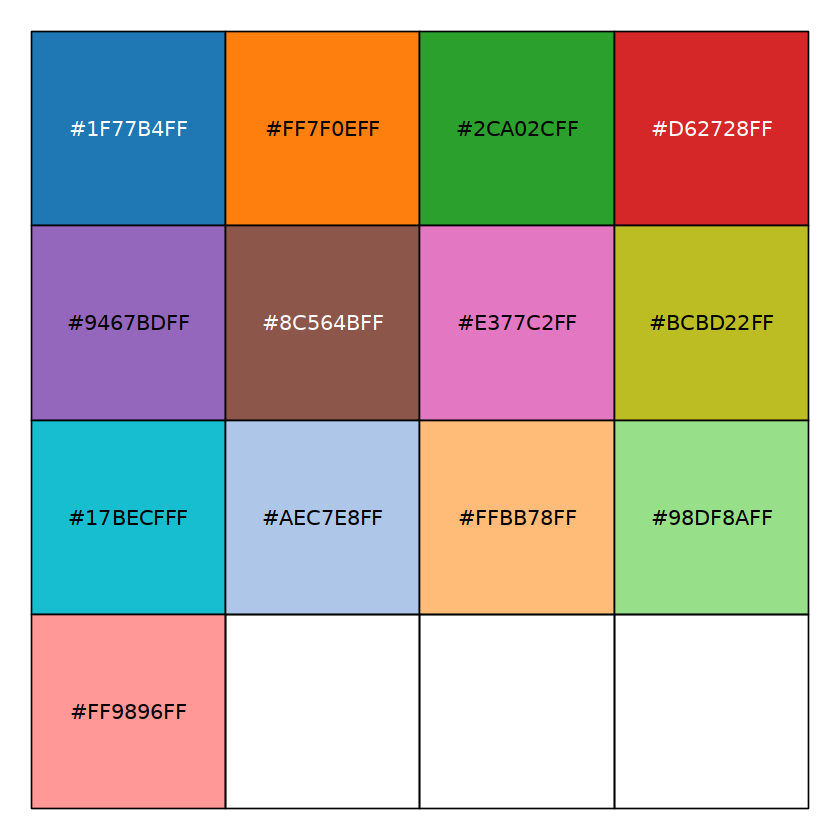

In [297]:
# 3.4 保存绘图数据到本地
#write.graph(graph,file = "graph.gml",format="gml") # 直接保存graph结构，gml能保存的graph信息最多。
net.data  <- igraph::as_data_frame(graph, what = "both")$edges # 提取链接属性
#write.csv(net.data,"net.data.csv",quote = FALSE,col.names = NA,row.names = FALSE) # 保存结果到本地。
head(net.data)
 
vertices  <- igraph::as_data_frame(graph, what = "both")$vertices # 提取节点属性
#write.csv(vertices,"vertices.csv",quote = FALSE,col.names = NA,row.names = FALSE)
head(vertices) # 直接读入此步保存的链接和节点属性文件，之后可直接生成graph或用于其他绘图软件绘图。

 
# 4.1 设置颜色
## 4.1.1 节点分组颜色
unique(vertices$group) # 7个分组信息
#??ggsci # 查看ggsci包帮助文件，选择颜色。
library(ggsci)
library(scales)
mycolor = pal_d3("category20",alpha = 1)(20)
mycolor
cols = mycolor[c(1:7,9:13,14)]
show_col(cols) # 以图形形式展示颜色
 
## 4.1.2 链接线颜色
#linetypes = c("positive" ="solid","negative" ="dashed") # 设置线类型
color = c("positive" ="#D62728FF","negative" ="#2CA02CFF")

In [298]:
 



 


 
# 4.2 方法1: 手动计算节点坐标
##添加标签角度数据
## seq()生成一组1-数据表行数的数值。
#number_of_bar<-nrow(vertices)
#vertices$id = seq(1, nrow(vertices))
#angle= 360 * (vertices$id-0.5) /number_of_bar 
#vertices$hjust<-ifelse(angle>180, 1, 0)
#vertices$angle<-ifelse(angle>180, 90-angle+180, 90-angle)
##物种与环境因子位于一个环上，则运行上面的代码。
 
## 4.2.1 为物种和环境因子标签分别生成角度
### 计算各类型变量总数
bar1 = nrow(vertices[vertices$group == "Inner",])
bar1 # 9个环境因子
bar2 = nrow(vertices[vertices$group != "Inner",])
bar2 # 17个物种
 
### 为各变量添加序号
vertices$id =1
vertices$id[vertices$group == "Inner"] = seq(1, bar1)
vertices$id[vertices$group != "Inner"] = seq(1, bar2)
head(vertices)
 
### 计算变量与轴的角度
vertices$var_angel <- NA
vertices$var_angel[vertices$group == "Inner"] <- 360 * (vertices$id[vertices$group == "Inner"]-0.5)/bar1 
vertices$var_angel[vertices$group != "Inner"] <- 360 * (vertices$id[vertices$group != "Inner"]-0.5)/bar2
 
### 计算物种和环境因子坐标-物种环半径设为1，环境因子环半径为0.5。
vertices$x <- ifelse(vertices$group == "Inner",cos(vertices$var_angel)/2,cos(vertices$var_angel))
vertices$y <- ifelse(vertices$group == "Inner",sin(vertices$var_angel)/2,sin(vertices$var_angel))
head(vertices)
 
## 4.2.2 为物种和环境因子标签添加hjust和angle属性
vertices$hjust <- ifelse(vertices$var_angel > 180, 1, 0)
vertices$angle <- ifelse(vertices$var_angel > 180, 90-vertices$var_angel+180, 90-vertices$var_angel)
 
## 4.2.3 内环的环境因子标签，设置为在节点中心水平放置
vertices$hjust[vertices$group == "Inner"] = "center" # 或0.5
vertices$angle[vertices$group == "Inner"] = 0
#write.csv(vertices,"vertices.csv",quote = FALSE,row.names = FALSE) #保存结果到本地
head(vertices)
 

 
## 4.2.4 将group属性加入链接属性表
net.data <- net.data %>% 
    left_join(vertices,by=c('from'='name')) 
#write.csv(net.data,"net.data.csv",quote = FALSE,row.names = FALSE) # 保存结果到本地
head(net.data)
 
## 4.2.5 重新构建graph结构数据
graph <- graph_from_data_frame(net.data, vertices = vertices, directed = FALSE)
graph

 
## 4.2.6 create_layout()创建布局数据，并将其中的(x,y)替换为上面计算的坐标。
layout <- create_layout(graph,layout = 'linear', circular = TRUE)
head(layout)
layout$x <- vertices$x
layout$y <- vertices$y
head(layout)

dim(layout)



 
# 4.3.4  绘制径向布局网络图2
##根据物种属设置节点颜色；
##节点degree设置节点大小；
##相关性正负设置链接线颜色；
##使用r绝对值大小设置链接线粗细。
Correlation <- guide_legend(title="Correlation",
                            direction="vertical",
                            order=2,# 图例排列序号
                            ncol=1,
                            byrow=FALSE,
                            title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                            label.theme = element_text(
                                           size = 12,colour = "black")
                             )
 
width_legend <- guide_legend(title="|r|",
                             direction="vertical",
                             order=1,# 图例排列序号
                             ncol=1,
                             byrow=FALSE,
                             title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                             label.theme = element_text(
                                           size = 12,colour = "black")
                   )
 
size_legend <- guide_legend(title="Degree",
                            direction="vertical",
                            order=3,# 图例排列序号
                            ncol=2, # 图例排两列
                            byrow=FALSE,
                            title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                            label.theme = element_text(
                                           size = 12,colour = "black")
                                         )
 
fill_legend <- guide_legend(title="Species",
                            direction="vertical",
                            order=4,# 图例排列序号
                            ncol=2,
                            byrow=FALSE,
                            title.theme = element_text(
                                           size = 14,
                                           face = "bold",
                                           colour = "black"),
                            label.theme = element_text(
                                           size = 12,
                                           colour = "black",face = "italic")
                                         )
 
set_graph_style(plot_margin = margin(0,0,1,0))
net.cir2 <- ggraph(layout) +
  geom_edge_arc(aes(edge_colour = as.factor(linecolor),
                    edge_width = abs(r)*0.01
                    ),
                edge_alpha=0.9 ) + # 改用曲线链接。
    scale_edge_colour_manual(values=color,
                          breaks = c("positive","negative"),
                          guide = Correlation) +
  scale_edge_width(
                   breaks = seq(0.2,1,0.2),
                   label = seq(0.2,1,0.2),
                   range = c(0.2,1),
                   guide = width_legend )+
  geom_node_point(aes(size=degree, fill=as.factor(group)),
                  shape=21,alpha=1) +
  scale_fill_manual(values=cols,
                    guide = fill_legend) +
  scale_size(
             breaks = seq(3,max(vertices$degree),3),
             label = seq(3,max(vertices$degree),3),
             range = c(5, 15),
             guide = size_legend)+
  geom_node_text(aes(x = x, y=y,
                     label= ifelse(V(graph)$group == "Inner",as.character(name),""),
                 angle=angle,hjust=hjust,
                 #color = as.factor(group)
                     ),
                 color = "black",# 所有节点标签设置为黑色。
                 size=4.75,# 14pt
                 show.legend = FALSE) +
  ##添加物种标签，取消下面代码的注释即可##
    #geom_node_text(aes(x = x*1.4, y=y*1.4, # 物种与环境因子标签的放置方式不同，最好分别设置，
                     #label= ifelse(V(graph)$group != "env",as.character(name),""),
                 #angle=angle,hjust=hjust,
                 #    ),
                 #color = "black",# 所有节点标签设置为黑色。
                 #size=4.75,# 14pt
                 #show.legend = FALSE) +
  coord_fixed()+
  theme_graph()
 
### 输出pdf格式图片到本地-输出到本地之后，可用AI或pdf编辑器删除物种标签，初期探索数据的时候，把标签加上比较好。
cairo_pdf("net.cir3.pdf",height=8,width=10,family="Times")
print(net.cir2) # 节点标签过长，可只展示种名。
dev.off()

[1] 5

[1] 751

,name,group,type,degree,id
,<chr>,<chr>,<chr>,<dbl>,<dbl>
g__Duncaniella_s__Duncaniella_sp..B8,g__Duncaniella_s__Duncaniella_sp..B8,Inner,Inner,212,1
g__Lactobacillus_s__Lactobacillus_murinus,g__Lactobacillus_s__Lactobacillus_murinus,Inner,Inner,283,2
g__Muribaculum_s__Muribaculum_intestinale,g__Muribaculum_s__Muribaculum_intestinale,Inner,Inner,105,3
g__Muribaculum_s__Muribaculum_sp..H5,g__Muribaculum_s__Muribaculum_sp..H5,Inner,Inner,109,4
g__Muribaculum_s__Muribaculum_sp..TLL.A4,g__Muribaculum_s__Muribaculum_sp..TLL.A4,Inner,Inner,303,5
g__Acaryochloris_s__Acaryochloris_marina,g__Acaryochloris_s__Acaryochloris_marina,Outer,Outer,1,1


,name,group,type,degree,id,var_angel,x,y
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g__Duncaniella_s__Duncaniella_sp..B8,g__Duncaniella_s__Duncaniella_sp..B8,Inner,Inner,212,1,36.0000000,-0.06398184,-0.4958894
g__Lactobacillus_s__Lactobacillus_murinus,g__Lactobacillus_s__Lactobacillus_murinus,Inner,Inner,283,2,108.0000000,0.18775480,0.4634093
g__Muribaculum_s__Muribaculum_intestinale,g__Muribaculum_s__Muribaculum_intestinale,Inner,Inner,105,3,180.0000000,-0.29923003,-0.4005763
g__Muribaculum_s__Muribaculum_sp..H5,g__Muribaculum_s__Muribaculum_sp..H5,Inner,Inner,109,4,252.0000000,0.39110605,0.3115061
g__Muribaculum_s__Muribaculum_sp..TLL.A4,g__Muribaculum_s__Muribaculum_sp..TLL.A4,Inner,Inner,303,5,324.0000000,-0.45736509,-0.2020326
g__Acaryochloris_s__Acaryochloris_marina,g__Acaryochloris_s__Acaryochloris_marina,Outer,Outer,1,1,0.2396804,0.97141389,0.2373922


,name,group,type,degree,id,var_angel,x,y,hjust,angle
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
g__Duncaniella_s__Duncaniella_sp..B8,g__Duncaniella_s__Duncaniella_sp..B8,Inner,Inner,212,1,36.0000000,-0.06398184,-0.4958894,center,0.00000
g__Lactobacillus_s__Lactobacillus_murinus,g__Lactobacillus_s__Lactobacillus_murinus,Inner,Inner,283,2,108.0000000,0.18775480,0.4634093,center,0.00000
g__Muribaculum_s__Muribaculum_intestinale,g__Muribaculum_s__Muribaculum_intestinale,Inner,Inner,105,3,180.0000000,-0.29923003,-0.4005763,center,0.00000
g__Muribaculum_s__Muribaculum_sp..H5,g__Muribaculum_s__Muribaculum_sp..H5,Inner,Inner,109,4,252.0000000,0.39110605,0.3115061,center,0.00000
g__Muribaculum_s__Muribaculum_sp..TLL.A4,g__Muribaculum_s__Muribaculum_sp..TLL.A4,Inner,Inner,303,5,324.0000000,-0.45736509,-0.2020326,center,0.00000
g__Acaryochloris_s__Acaryochloris_marina,g__Acaryochloris_s__Acaryochloris_marina,Outer,Outer,1,1,0.2396804,0.97141389,0.2373922,0,89.76032


,from,to,r,p,linecolor,linesize,weight,group,type,degree,id,var_angel,x,y,hjust,angle
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,g__Duncaniella_s__Duncaniella_sp..B8,g__Acidiphilium_s__Acidiphilium_multivorum,0.8571429,**,positive,0.8571429,1,Inner,Inner,212,1,36,-0.06398184,-0.4958894,center,0
2,g__Duncaniella_s__Duncaniella_sp..B8,g__Acidobacterium_s__Acidobacterium_capsulatum,0.8554838,**,positive,0.8554838,1,Inner,Inner,212,1,36,-0.06398184,-0.4958894,center,0
3,g__Duncaniella_s__Duncaniella_sp..B8,g__Acinetobacter_s__Acinetobacter_larvae,0.8571429,**,positive,0.8571429,1,Inner,Inner,212,1,36,-0.06398184,-0.4958894,center,0
4,g__Duncaniella_s__Duncaniella_sp..B8,g__Actinobacillus_s__Actinobacillus_delphinicola,0.8783101,**,positive,0.8783101,1,Inner,Inner,212,1,36,-0.06398184,-0.4958894,center,0
5,g__Duncaniella_s__Duncaniella_sp..B8,g__Actinomyces_s__Actinomyces_sp. oral taxon 848,0.8503146,**,positive,0.8503146,1,Inner,Inner,212,1,36,-0.06398184,-0.4958894,center,0
6,g__Duncaniella_s__Duncaniella_sp..B8,g__Actinopolyspora_s__Actinopolyspora_erythraea,0.8571429,**,positive,0.8571429,1,Inner,Inner,212,1,36,-0.06398184,-0.4958894,center,0


IGRAPH 9e16559 UNWB 756 1012 -- 
+ attr: name (v/c), group (v/c), type (v/c), degree (v/n), id (v/n),
| var_angel (v/n), x (v/n), y (v/n), hjust (v/c), angle (v/n), r (e/n),
| p (e/c), linecolor (e/c), linesize (e/n), weight (e/n), group (e/c),
| type (e/c), degree (e/n), id (e/n), var_angel (e/n), x (e/n), y
| (e/n), hjust (e/c), angle (e/n)
+ edges from 9e16559 (vertex names):
[1] g__Duncaniella_s__Duncaniella_sp..B8--g__Acidiphilium_s__Acidiphilium_multivorum    
[2] g__Duncaniella_s__Duncaniella_sp..B8--g__Acidobacterium_s__Acidobacterium_capsulatum
[3] g__Duncaniella_s__Duncaniella_sp..B8--g__Acinetobacter_s__Acinetobacter_larvae      
+ ... omitted several edges

Warning message:
“Existing variables `x` and `y` overwritten by layout variables”


,x,y,name,group,type,degree,id,var_angel,hjust,angle,.ggraph.orig_index,circular,.ggraph.index
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<lgl>,<int>
1,0.004155534,0.9999914,g__Duncaniella_s__Duncaniella_sp..B8,Inner,Inner,212,1,36.0000000,center,0.00000,1,TRUE,1
2,0.012466315,0.9999223,g__Lactobacillus_s__Lactobacillus_murinus,Inner,Inner,283,2,108.0000000,center,0.00000,2,TRUE,2
3,0.020776234,0.9997842,g__Muribaculum_s__Muribaculum_intestinale,Inner,Inner,105,3,180.0000000,center,0.00000,3,TRUE,3
4,0.029084719,0.9995770,g__Muribaculum_s__Muribaculum_sp..H5,Inner,Inner,109,4,252.0000000,center,0.00000,4,TRUE,4
5,0.037391194,0.9993007,g__Muribaculum_s__Muribaculum_sp..TLL.A4,Inner,Inner,303,5,324.0000000,center,0.00000,5,TRUE,5
6,0.045695087,0.9989554,g__Acaryochloris_s__Acaryochloris_marina,Outer,Outer,1,1,0.2396804,0,89.76032,6,TRUE,6


,x,y,name,group,type,degree,id,var_angel,hjust,angle,.ggraph.orig_index,circular,.ggraph.index
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<lgl>,<int>
1,-0.06398184,-0.4958894,g__Duncaniella_s__Duncaniella_sp..B8,Inner,Inner,212,1,36.0000000,center,0.00000,1,TRUE,1
2,0.18775480,0.4634093,g__Lactobacillus_s__Lactobacillus_murinus,Inner,Inner,283,2,108.0000000,center,0.00000,2,TRUE,2
3,-0.29923003,-0.4005763,g__Muribaculum_s__Muribaculum_intestinale,Inner,Inner,105,3,180.0000000,center,0.00000,3,TRUE,3
4,0.39110605,0.3115061,g__Muribaculum_s__Muribaculum_sp..H5,Inner,Inner,109,4,252.0000000,center,0.00000,4,TRUE,4
5,-0.45736509,-0.2020326,g__Muribaculum_s__Muribaculum_sp..TLL.A4,Inner,Inner,303,5,324.0000000,center,0.00000,5,TRUE,5
6,0.97141389,0.2373922,g__Acaryochloris_s__Acaryochloris_marina,Outer,Outer,1,1,0.2396804,0,89.76032,6,TRUE,6


[1] 756  13

png 
  2

In [50]:
library(ggplot2)
library(ggraph)

Warning message:
“package ‘ggraph’ was built under R version 4.2.3”
